# Stage 1

In [1]:
test_sentence = "You are the worst person I know"

In [1]:
# CyberBullyingClassifier

from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer


model_path = "./trained_bert_cyberbullying_mendeley"

model = AutoModelForSequenceClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)

trainer = Trainer(model=model)

/Users/stygianphantom/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/stygianphantom/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x107614580>>
Traceback (most recent call last):
  File "/Users/stygianphantom/Library/Python/3.9/lib/python/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


In [116]:
import torch
import torch.nn.functional as F
from captum.attr import LayerIntegratedGradients

# Ensure the model is on CPU
device = torch.device("cpu")
model.to(device)

# Tokenize and prepare input
inputs = tokenizer(test_sentence, return_tensors="pt", truncation=True, padding=True, max_length=128)
inputs = {key: value.to(device) for key, value in inputs.items()}

# Run inference
with torch.no_grad():
    outputs = model(**inputs)

# Get logits and predicted class
logits = outputs.logits
predicted_class = torch.argmax(logits, dim=1).item()

# Get prediction confidence
probs = F.softmax(logits, dim=1)
confidence = probs[0, predicted_class].item()

# Map predicted class to label
label_map = {1: "Not Cyberbullying", 0: "Cyberbullying"}
result = label_map[predicted_class]

print(f"Prediction: {result} (Confidence: {confidence:.2%})")

# Define a forward function for IG
def forward_func(input_ids, attention_mask):
    output = model(input_ids=input_ids, attention_mask=attention_mask)
    return output.logits[:, predicted_class]

# Get embedding layer
embedding_layer = model.get_input_embeddings()

# Setup Layer Integrated Gradients
lig = LayerIntegratedGradients(forward_func, embedding_layer)

# Create baseline (PAD tokens)
baseline_input_ids = torch.full_like(inputs["input_ids"], tokenizer.pad_token_id).to(device)

# Compute attributions
attributions, delta = lig.attribute(
    inputs=(inputs["input_ids"], inputs["attention_mask"]),
    baselines=(baseline_input_ids, inputs["attention_mask"]),
    return_convergence_delta=True
)

# Sum attributions across embeddings
attributions_sum = attributions.sum(dim=-1).squeeze(0)

# Decode tokens
tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"].squeeze().tolist())

# Display token-level attributions
print("\nToken Attributions (Layer Integrated Gradients):")
for token, score in zip(tokens, attributions_sum.detach().cpu().numpy()):
    print(f"{token}: {score:.4f}")


Prediction: Cyberbullying (Confidence: 99.72%)

Token Attributions (Layer Integrated Gradients):
[CLS]: 0.5309
you: 0.4722
are: 0.3987
the: 1.6299
worst: 2.6743
person: 0.6498
i: 0.8518
know: 0.5079
[SEP]: 0.4447


### Hatespeech classifier

In [117]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# Step 1: Load model and tokenizer
hate_model_path = "hate_speech_recall_optimized_model"

hate_tokenizer = AutoTokenizer.from_pretrained(hate_model_path)
hate_model = AutoModelForSequenceClassification.from_pretrained(hate_model_path, output_attentions=True)
hate_model.eval()

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
hate_model.to(device)

# === Step 2: Input sentence ===
inputs = hate_tokenizer(test_sentence, return_tensors="pt", truncation=True, padding=True)
inputs = {k: v.to(device) for k, v in inputs.items()}

# === Step 3: Forward pass ===
with torch.no_grad():
    outputs = hate_model(**inputs)
    logits = outputs.logits.cpu().numpy()
    attentions = outputs.attentions  # shape: (num_layers, batch_size, num_heads, seq_len, seq_len)

# === Step 4: Apply sigmoid and threshold ===
hate_probs = 1 / (1 + np.exp(-logits))  # Sigmoid
preds = (hate_probs > 0.51).astype(int).flatten()

# === Step 5: Optional - If true label is known, compute metrics ===
# Dummy label for demo (replace with real one if available)
labels = np.array([1])
print("Prediction:", preds[0])
print("Probability:", hate_probs[0][0])


# === Step 6: Attention weights from [CLS] token ===
last_layer_attention = attentions[-1]  # last layer: (1, num_heads, seq_len, seq_len)
attention_matrix = last_layer_attention[0][0]  # head 0 → shape: (seq_len, seq_len)
cls_attention = attention_matrix[0]  # [CLS] token attends to others → shape: (seq_len,)

# Decode tokens
tokens = hate_tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

# Show token attention weights
print("\nAttention weights from [CLS] to each token:")
for token, weight in zip(tokens, cls_attention):
    print(f"{token}: {weight.item():.4f}")

Prediction: 1
Probability: 0.6927011

Attention weights from [CLS] to each token:
[CLS]: 0.0000
[UNK]: 0.0026
are: 0.0000
the: 0.0545
worst: 0.1406
person: 0.0195
[UNK]: 0.0032
know: 0.0000
[SEP]: 0.7795


In [118]:
# Sentence target
import spacy

nlp = spacy.load("en_core_web_lg")

# Set of pronouns we consider as PERSONs
PERSON_PRONOUNS = {"you", "he", "she", "they", "him", "her"}

def detect_person_targets(text):
    doc = nlp(text)

    person_tokens = []

    for token in doc:
        # Add pronouns like "you", "he", etc.
        if token.text.lower() in PERSON_PRONOUNS:
            person_tokens.append(token.text)
    
    # Add spaCy named PERSON entities
    for ent in doc.ents:
        if ent.label_ == "PERSON":
            person_tokens.append(ent.text)

    # Remove duplicates and preserve order
    seen = set()
    unique_persons = [p for p in person_tokens if not (p.lower() in seen or seen.add(p.lower()))]

    return {
        "person_tokens": unique_persons,
        "is_directed_towards_someone": len(unique_persons) > 0
    }

ner_person = detect_person_targets(test_sentence)

In [119]:
stage_1_prob = 0.7*confidence + 0.3*int(ner_person['is_directed_towards_someone'])*hate_probs[0][0]

print(stage_1_prob)

0.9058240115642546


In [120]:
import torch
import numpy as np
from scipy.special import softmax
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# ✅ Load models and tokenizers
roberta_name = "cardiffnlp/twitter-roberta-base-sentiment"
bertweet_name = "finiteautomata/bertweet-base-sentiment-analysis"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load RoBERTa
roberta_tokenizer = AutoTokenizer.from_pretrained(roberta_name)
roberta_model = AutoModelForSequenceClassification.from_pretrained(roberta_name).to(device).eval()

# Load BERTweet
bertweet_tokenizer = AutoTokenizer.from_pretrained(bertweet_name, use_fast=False)
bertweet_model = AutoModelForSequenceClassification.from_pretrained(bertweet_name).to(device).eval()

def predict_sentiment(text):
    # RoBERTa prediction
    roberta_inputs = roberta_tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=128).to(device)
    with torch.no_grad():
        roberta_logits = roberta_model(**roberta_inputs).logits
    roberta_probs = softmax(roberta_logits.cpu().numpy(), axis=1)[0]

    # BERTweet prediction
    bertweet_inputs = bertweet_tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=128).to(device)
    with torch.no_grad():
        bertweet_logits = bertweet_model(**bertweet_inputs).logits
    bertweet_probs = softmax(bertweet_logits.cpu().numpy(), axis=1)[0]

    # Weighted ensemble
    final_probs = np.array([
        0.6 * roberta_probs[0] + 0.4 * bertweet_probs[0],  # Negative
        0.4 * roberta_probs[1] + 0.6 * bertweet_probs[1],  # Neutral
        0.6 * roberta_probs[2] + 0.4 * bertweet_probs[2],  # Positive
    ])
    pred = np.argmax(final_probs)
    label_map = {0: "Negative", 1: "Neutral", 2: "Positive"}

    return {
        "text": text,
        "predicted_label": label_map[pred],
        "probabilities": {
            "Negative": round(final_probs[0], 4),
            "Neutral": round(final_probs[1], 4),
            "Positive": round(final_probs[2], 4),
        }
    }

text = "Oh great, another delay. Just what I needed."
result = predict_sentiment(text)
print(result)


{'text': 'Oh great, another delay. Just what I needed.', 'predicted_label': 'Negative', 'probabilities': {'Negative': 0.4757, 'Neutral': 0.1588, 'Positive': 0.2962}}


# Sentiment

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import load_dataset
import evaluate

# ✅ Step 3: Load TweetEval Sentiment dataset
dataset = load_dataset("tweet_eval", "sentiment")
# ✅ Step 4: Load tokenizer and model
model_name = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)
def tokenize(batch):
    return tokenizer(batch["text"], truncation=True, padding="max_length", max_length=128)

tokenized_ds = dataset.map(tokenize, batched=True)
tokenized_ds = tokenized_ds.remove_columns(["text"])
tokenized_ds.set_format("torch")
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)
    return accuracy.compute(predictions=predictions, references=labels)
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy"
)
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_ds["train"],
    eval_dataset=tokenized_ds["validation"],
    compute_metrics=compute_metrics
)

trainer.train()
results = trainer.evaluate(tokenized_ds["test"])
print("Test Accuracy:", results["eval_accuracy"])

/Users/stygianphantom/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/stygianphantom/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Map: 100%|██████████| 2000/2000 [00:00<00:00, 34870.59 examples/s]
/Users/stygianphantom/Library/Python/3.9/lib/python/site-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.463900,0.451365,0.806500
2,0.312900,0.499581,0.813500
3,0.181500,0.685920,0.816500


Test Accuracy: 0.7032725496580918


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import load_dataset
from torch.utils.data import DataLoader
import torch
from sklearn.metrics import accuracy_score

# Load dataset and model
dataset = load_dataset("tweet_eval", "sentiment")
model_name = "vinai/bertweet-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name).to("cuda" if torch.cuda.is_available() else "cpu")

# Tokenize test set
def tokenize(batch):
    return tokenizer(batch["text"], truncation=True, padding="max_length", max_length=128)

tokenized_test = dataset["test"].map(tokenize, batched=True)
tokenized_test.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

# Run inference
model.eval()
dataloader = DataLoader(tokenized_test, batch_size=32)
all_preds = []
all_labels = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

with torch.no_grad():
    for batch in dataloader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)
        
        outputs = model(input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute accuracy
acc = accuracy_score(all_labels, all_preds)
print("📊 Baseline Test Accuracy:", round(acc * 100, 2), "%")


emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 12284/12284 [00:01<00:00, 7032.05 examples/s]


📊 Baseline Test Accuracy: 48.06 %


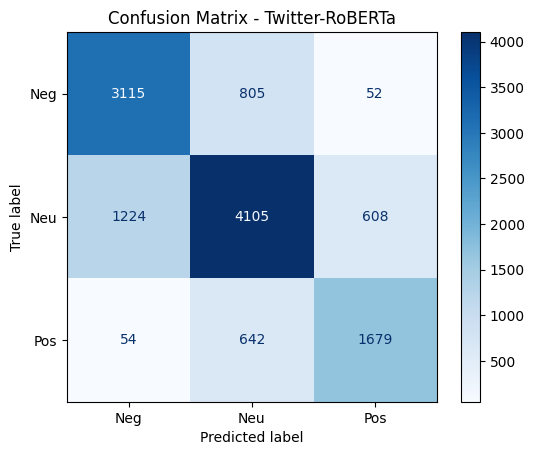

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Neg", "Neu", "Pos"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Twitter-RoBERTa")
plt.show()


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import load_dataset
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Step 1: Load IMDb (binary: 0=neg, 1=pos)
dataset = load_dataset("imdb", split="test[:2000]")

# Step 2: Convert to 3-class format:
# 0 → 0 (negative), 1 → 2 (positive)
label_map = {0: 0, 1: 2}
dataset = dataset.map(lambda x: {"label_3class": label_map[x["label"]]})

# Step 3: Load tokenizer and model
model_name = "cardiffnlp/twitter-roberta-base-sentiment"  # 3-class
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# Step 4: Tokenization helper
def tokenize(text):
    return tokenizer(text, truncation=True, padding="max_length", max_length=128, return_tensors="pt")

# Step 5: Inference loop
all_preds, all_labels = [], []

for example in dataset:
    inputs = tokenize(example["text"])
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        logits = model(**inputs).logits
        pred = torch.argmax(logits).item()
    
    all_preds.append(pred)
    all_labels.append(example["label_3class"])

# Step 6: Filter out Neutrals (pred = 1), since we care only about Pos/Neg
filtered_preds = []
filtered_labels = []

for pred, label in zip(all_preds, all_labels):
    if pred != 1:  # Ignore predicted neutrals
        filtered_preds.append(pred)
        filtered_labels.append(label)

# Step 7: Evaluate
target_names = ["Negative", "Neutral (not predicted)", "Positive"]
print(classification_report(filtered_labels, filtered_preds, labels=[0,2], target_names=["Negative", "Positive"]))

cm = confusion_matrix(filtered_labels, filtered_preds, labels=[0,2])
print("Confusion Matrix:\n", cm)


Map: 100%|██████████| 2000/2000 [00:00<00:00, 42870.54 examples/s]


              precision    recall  f1-score   support

    Negative       1.00      0.88      0.93      1677
    Positive       0.00      0.00      0.00         0

    accuracy                           0.88      1677
   macro avg       0.50      0.44      0.47      1677
weighted avg       1.00      0.88      0.93      1677

Confusion Matrix:
 [[1468  209]
 [   0    0]]


/Users/stygianphantom/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/stygianphantom/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/stygianphantom/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

In [ ]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import classification_report
import torch
from tqdm import tqdm

# ✅ Step 1: Load dataset
df = pd.read_csv("./archive (2)/Tweets.csv")  # Update this if your file is in a different path
df = df[["text", "airline_sentiment"]].dropna()

# ✅ Step 2: Map sentiment labels to integers
label_map = {"negative": 0, "neutral": 1, "positive": 2}
df = df[df["airline_sentiment"].isin(label_map.keys())]
df["label"] = df["airline_sentiment"].map(label_map)

# ✅ Step 3: Load model & tokenizer
model_name = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# ✅ Step 4: Evaluate
all_preds = []
all_labels = []

for _, row in tqdm(df.iterrows(), total=len(df)):
    inputs = tokenizer(row["text"], truncation=True, padding="max_length", max_length=128, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    with torch.no_grad():
        logits = model(**inputs).logits
        pred = torch.argmax(logits, dim=1).item()

    all_preds.append(pred)
    all_labels.append(row["label"])

# ✅ Step 5: Report
print(classification_report(all_labels, all_preds, target_names=["Negative", "Neutral", "Positive"]))


100%|██████████| 14640/14640 [09:57<00:00, 24.51it/s]

              precision    recall  f1-score   support

    Negative       0.94      0.71      0.81      9178
     Neutral       0.48      0.70      0.57      3099
    Positive       0.67      0.90      0.77      2363

    accuracy                           0.74     14640
   macro avg       0.70      0.77      0.71     14640
weighted avg       0.80      0.74      0.75     14640



In [1]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import classification_report
import torch
from tqdm import tqdm

# ✅ Step 1: Load dataset
df = pd.read_csv("./archive (2)/Tweets.csv")  # Update the path if needed
df = df[["text", "airline_sentiment"]].dropna()

# ✅ Step 2: Map sentiment labels to integers
label_map = {"negative": 0, "neutral": 1, "positive": 2}
df = df[df["airline_sentiment"].isin(label_map.keys())]
df["label"] = df["airline_sentiment"].map(label_map)

# ✅ Step 3: Load model & tokenizer
model_name = "finiteautomata/bertweet-base-sentiment-analysis"
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=False)  # BERTweet needs use_fast=False
model = AutoModelForSequenceClassification.from_pretrained(model_name)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# ✅ Step 4: Evaluate
all_preds = []
all_labels = []

for _, row in tqdm(df.iterrows(), total=len(df)):
    inputs = tokenizer(row["text"], truncation=True, padding="max_length", max_length=128, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    with torch.no_grad():
        logits = model(**inputs).logits
        pred = torch.argmax(logits, dim=1).item()

    all_preds.append(pred)
    all_labels.append(row["label"])

# ✅ Step 5: Report
print(classification_report(all_labels, all_preds, target_names=["Negative", "Neutral", "Positive"]))

/Users/stygianphantom/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/stygianphantom/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 14640/14640 [10:15<00:00, 23.78it/s]


              precision    recall  f1-score   support

    Negative       0.93      0.80      0.86      9178
     Neutral       0.55      0.65      0.60      3099
    Positive       0.68      0.89      0.77      2363

    accuracy                           0.79     14640
   macro avg       0.72      0.78      0.74     14640
weighted avg       0.81      0.79      0.79     14640



In [ ]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import classification_report
import torch
from scipy.special import softmax
from tqdm import tqdm

# Load data
df = pd.read_csv("./archive (2)/Tweets.csv")
df = df[["text", "airline_sentiment"]].dropna()
label_map = {"negative": 0, "neutral": 1, "positive": 2}
df = df[df["airline_sentiment"].isin(label_map)]
df["label"] = df["airline_sentiment"].map(label_map)

# Load models & tokenizers
roberta_name = "cardiffnlp/twitter-roberta-base-sentiment"
bertweet_name = "finiteautomata/bertweet-base-sentiment-analysis"

roberta_tokenizer = AutoTokenizer.from_pretrained(roberta_name)
roberta_model = AutoModelForSequenceClassification.from_pretrained(roberta_name).to("cuda" if torch.cuda.is_available() else "cpu")
roberta_model.eval()

bertweet_tokenizer = AutoTokenizer.from_pretrained(bertweet_name, use_fast=False)
bertweet_model = AutoModelForSequenceClassification.from_pretrained(bertweet_name).to("cuda" if torch.cuda.is_available() else "cpu")
bertweet_model.eval()

# Inference
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
all_preds, all_labels = [], []

for _, row in tqdm(df.iterrows(), total=len(df)):
    text = row["text"]

    # Roberta
    roberta_inputs = roberta_tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=128).to(device)
    with torch.no_grad():
        roberta_logits = roberta_model(**roberta_inputs).logits
    roberta_probs = softmax(roberta_logits.cpu().numpy(), axis=1)

    # BERTweet
    bertweet_inputs = bertweet_tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=128).to(device)
    with torch.no_grad():
        bertweet_logits = bertweet_model(**bertweet_inputs).logits
    bertweet_probs = softmax(bertweet_logits.cpu().numpy(), axis=1)

    # Ensemble: average probs
    avg_probs = (roberta_probs + bertweet_probs) / 2
    pred = avg_probs.argmax(axis=1).item()

    all_preds.append(pred)
    all_labels.append(row["label"])

# Evaluate
print(classification_report(all_labels, all_preds, target_names=["Negative", "Neutral", "Positive"]))


100%|██████████| 14640/14640 [18:25<00:00, 13.24it/s]

              precision    recall  f1-score   support

    Negative       0.94      0.79      0.86      9178
     Neutral       0.55      0.67      0.61      3099
    Positive       0.68      0.91      0.78      2363

    accuracy                           0.78     14640
   macro avg       0.72      0.79      0.75     14640
weighted avg       0.81      0.78      0.79     14640



In [ ]:
# Re-import required modules after code execution environment reset
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import classification_report
import torch
from scipy.special import softmax
from tqdm import tqdm
import numpy as np

# Reload the uploaded CSV
df = pd.read_csv("./archive (2)/Tweets.csv")
df = df[["text", "airline_sentiment"]].dropna()
label_map = {"negative": 0, "neutral": 1, "positive": 2}
df = df[df["airline_sentiment"].isin(label_map)]
df["label"] = df["airline_sentiment"].map(label_map)

# Load models
roberta_name = "cardiffnlp/twitter-roberta-base-sentiment"
bertweet_name = "finiteautomata/bertweet-base-sentiment-analysis"

roberta_tokenizer = AutoTokenizer.from_pretrained(roberta_name)
roberta_model = AutoModelForSequenceClassification.from_pretrained(roberta_name).to("cuda" if torch.cuda.is_available() else "cpu")
roberta_model.eval()

bertweet_tokenizer = AutoTokenizer.from_pretrained(bertweet_name, use_fast=False)
bertweet_model = AutoModelForSequenceClassification.from_pretrained(bertweet_name).to("cuda" if torch.cuda.is_available() else "cpu")
bertweet_model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
all_preds, all_labels = [], []

# Weighted ensemble inference
for _, row in tqdm(df.iterrows(), total=len(df)):
    text = row["text"]

    # RoBERTa prediction
    roberta_inputs = roberta_tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=128).to(device)
    with torch.no_grad():
        roberta_logits = roberta_model(**roberta_inputs).logits
    roberta_probs = softmax(roberta_logits.cpu().numpy(), axis=1)

    # BERTweet prediction
    bertweet_inputs = bertweet_tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=128).to(device)
    with torch.no_grad():
        bertweet_logits = bertweet_model(**bertweet_inputs).logits
    bertweet_probs = softmax(bertweet_logits.cpu().numpy(), axis=1)

    # Weighted softmax ensemble per class
    final_probs = np.stack([
        0.6 * roberta_probs[0][0] + 0.4 * bertweet_probs[0][0],  # Negative
        0.4 * roberta_probs[0][1] + 0.6 * bertweet_probs[0][1],  # Neutral (less focus)
        0.6 * roberta_probs[0][2] + 0.4 * bertweet_probs[0][2],  # Positive
    ])
    pred = np.argmax(final_probs)

    all_preds.append(pred)
    all_labels.append(row["label"])

# Generate classification report
report = classification_report(all_labels, all_preds, target_names=["Negative", "Neutral", "Positive"], output_dict=True)
report


100%|██████████| 14640/14640 [18:26<00:00, 13.23it/s]


{'Negative': {'precision': 0.9379885356956749,
  'recall': 0.7844846371758553,
  'f1-score': 0.8543965824136703,
  'support': 9178.0},
 'Neutral': {'precision': 0.5515873015873016,
  'recall': 0.6727976766698935,
  'f1-score': 0.6061927605756651,
  'support': 3099.0},
 'Positive': {'precision': 0.6733668341708543,
  'recall': 0.9073212018620398,
  'f1-score': 0.7730304669190553,
  'support': 2363.0},
 'accuracy': 0.7806693989071039,
 'macro avg': {'precision': 0.7209808904846103,
  'recall': 0.7882011719025961,
  'f1-score': 0.7445399366361302,
  'support': 14640.0},
 'weighted avg': {'precision': 0.8134831733182842,
  'recall': 0.7806693989071039,
  'f1-score': 0.7887236469772118,
  'support': 14640.0}}

In [ ]:
# Re-import required modules after code execution environment reset
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import classification_report
import torch
from scipy.special import softmax
from tqdm import tqdm
import numpy as np

# Load dataset
df = pd.read_csv("./archive (2)/Tweets.csv")
df = df[["text", "airline_sentiment"]].dropna()
label_map = {"negative": 0, "neutral": 1, "positive": 2}
df = df[df["airline_sentiment"].isin(label_map)]
df["label"] = df["airline_sentiment"].map(label_map)

# Load models
roberta_name = "cardiffnlp/twitter-roberta-base-sentiment"
bertweet_name = "finiteautomata/bertweet-base-sentiment-analysis"

roberta_tokenizer = AutoTokenizer.from_pretrained(roberta_name)
roberta_model = AutoModelForSequenceClassification.from_pretrained(roberta_name).to("cuda" if torch.cuda.is_available() else "cpu")
roberta_model.eval()

bertweet_tokenizer = AutoTokenizer.from_pretrained(bertweet_name, use_fast=False)
bertweet_model = AutoModelForSequenceClassification.from_pretrained(bertweet_name).to("cuda" if torch.cuda.is_available() else "cpu")
bertweet_model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
all_preds, all_labels = [], []

# 🎯 Weighted ensemble class-wise weights
# weights = {
#     "negative": (0.7, 0.3),  # 70% RoBERTa, 30% BERTweet
#     "neutral":  (0.4, 0.6),  # less RoBERTa bias, more BERTweet for neutral
#     "positive": (0.6, 0.4)   # slightly more RoBERTa
# }

weights = {
    "negative": (0.85, 0.15),
    "neutral":  (0.35, 0.65),
    "positive": (0.6, 0.4)
}

# Inference loop
for _, row in tqdm(df.iterrows(), total=len(df)):
    text = row["text"]

    # RoBERTa
    roberta_inputs = roberta_tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=128).to(device)
    with torch.no_grad():
        roberta_logits = roberta_model(**roberta_inputs).logits
    roberta_probs = softmax(roberta_logits.cpu().numpy(), axis=1)[0]

    # BERTweet
    bertweet_inputs = bertweet_tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=128).to(device)
    with torch.no_grad():
        bertweet_logits = bertweet_model(**bertweet_inputs).logits
    bertweet_probs = softmax(bertweet_logits.cpu().numpy(), axis=1)[0]

    # Apply class-wise weighted averaging
    final_probs = np.array([
        weights["negative"][0] * roberta_probs[0] + weights["negative"][1] * bertweet_probs[0],
        weights["neutral"][0]  * roberta_probs[1] + weights["neutral"][1]  * bertweet_probs[1],
        weights["positive"][0] * roberta_probs[2] + weights["positive"][1] * bertweet_probs[2],
    ])
    pred = np.argmax(final_probs)

    all_preds.append(pred)
    all_labels.append(row["label"])

# Evaluation
report = classification_report(all_labels, all_preds, target_names=["Negative", "Neutral", "Positive"], output_dict=True)
report


100%|██████████| 14640/14640 [17:54<00:00, 13.63it/s]


{'Negative': {'precision': 0.9419518040207695,
  'recall': 0.7708651122248856,
  'f1-score': 0.8478638624243514,
  'support': 9178.0},
 'Neutral': {'precision': 0.5418693982074264,
  'recall': 0.6828009035172636,
  'f1-score': 0.6042261564820103,
  'support': 3099.0},
 'Positive': {'precision': 0.6659429280397022,
  'recall': 0.9085907744392722,
  'f1-score': 0.768569894397709,
  'support': 2363.0},
 'accuracy': 0.7744535519125683,
 'macro avg': {'precision': 0.7165880434226327,
  'recall': 0.7874189300604738,
  'f1-score': 0.7402199711013568,
  'support': 14640.0},
 'weighted avg': {'precision': 0.8127124358815063,
  'recall': 0.7744535519125683,
  'f1-score': 0.7834919432192782,
  'support': 14640.0}}

# Sarcasm

In [ ]:
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from torch.nn.functional import softmax

# Replace with the actual path to your model folder
model_dir = "./sarcasmDetection"

# Load tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained(model_dir)
model = DistilBertForSequenceClassification.from_pretrained(model_dir)
model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def predict_sarcasm(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128).to(device)
    
    with torch.no_grad():
        outputs = model(**inputs)
        probs = softmax(outputs.logits, dim=1).cpu().numpy()[0]
        pred_class = int(probs.argmax())
    
    return {
        "is_sarcastic": bool(pred_class),
        "prob_sarcastic": float(probs[1]),
        "prob_not_sarcastic": float(probs[0])
    }

# Example usage
example_text = "sure, because three hours of sleep is all I ever needed to be productive."
result = predict_sarcasm(example_text)
print(result)


{'is_sarcastic': False, 'prob_sarcastic': 0.013367267325520515, 'prob_not_sarcastic': 0.9866327047348022}


# The combination

In [5]:
!pip -V
import sys
print(sys.version)

! pip install numpy
! pip install pandas==2.0.3
! pip install torch==2.0.1
! pip install transformers==4.30.0
! pip install scipy==1.10.1
! pip install scikit-learn==1.3.2
! pip install spacy==3.5.0


# =============================================================================
# Full Code - Feature Extraction + Linear Regression
# =============================================================================

# import os
# import numpy as np
# import pandas as pd
# import torch
# import torch.nn.functional as F
# import matplotlib.pyplot as plt

# from transformers import AutoTokenizer, AutoModelForSequenceClassification
# from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LinearRegression
# from sklearn.metrics import mean_squared_error, r2_score
# import spacy

# # Set device for inference
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # =============================================================================
# # 1. Load Pretrained Models and Tokenizers
# # =============================================================================

# # --- Cyberbullying Model ---
# cyber_model_path = "./trained_bert_cyberbullying_mendeley"
# cyber_model = AutoModelForSequenceClassification.from_pretrained(cyber_model_path)
# cyber_tokenizer = AutoTokenizer.from_pretrained(cyber_model_path)
# cyber_model.to(device)
# cyber_model.eval()

# # --- Hate Speech Model ---
# hate_model_path = "hate_speech_recall_optimized_model"
# hate_model = AutoModelForSequenceClassification.from_pretrained(hate_model_path, output_attentions=True)
# hate_tokenizer = AutoTokenizer.from_pretrained(hate_model_path)
# hate_model.to(device)
# hate_model.eval()

# # --- Sentiment Models (RoBERTa & BERTweet) ---
# roberta_name = "cardiffnlp/twitter-roberta-base-sentiment"
# roberta_model = AutoModelForSequenceClassification.from_pretrained(roberta_name)
# roberta_tokenizer = AutoTokenizer.from_pretrained(roberta_name)
# roberta_model.to(device)
# roberta_model.eval()

# bertweet_name = "finiteautomata/bertweet-base-sentiment-analysis"
# bertweet_model = AutoModelForSequenceClassification.from_pretrained(bertweet_name)
# bertweet_tokenizer = AutoTokenizer.from_pretrained(bertweet_name, use_fast=False)
# bertweet_model.to(device)
# bertweet_model.eval()

# # --- Sarcasm Detection Model ---
# sarcasm_model_path = "helinivan/english-sarcasm-detector"
# sarcasm_model = AutoModelForSequenceClassification.from_pretrained(sarcasm_model_path)
# sarcasm_tokenizer = AutoTokenizer.from_pretrained(sarcasm_model_path)
# sarcasm_model.to(device)
# sarcasm_model.eval()

# # --- spaCy NER Model ---
# nlp = spacy.load("en_core_web_lg")

# # =============================================================================
# # 2. Define Helper Functions to Extract Features
# # =============================================================================

# def get_cyberbullying_confidence(text):
#     inputs = cyber_tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
#     inputs = {k: v.to(device) for k, v in inputs.items()}
#     with torch.no_grad():
#         outputs = cyber_model(**inputs)
#     probs = F.softmax(outputs.logits, dim=1)
#     predicted_class = torch.argmax(probs, dim=1).item()
#     confidence = probs[0, predicted_class].item()
#     if predicted_class == 0:
#         return confidence
#     else:
#         return 1 - confidence

# def get_hate_speech_prob(text):
#     inputs = hate_tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
#     inputs = {k: v.to(device) for k, v in inputs.items()}
#     with torch.no_grad():
#         outputs = hate_model(**inputs)
#     logits = outputs.logits
#     hate_prob = 1 / (1 + np.exp(-logits.cpu().numpy()))
#     return hate_prob[0][0]

# def get_target_detection(text):
#     PERSON_PRONOUNS = {"you", "he", "she", "they", "him", "her"}
#     doc = nlp(text)
#     found = False
#     for token in doc:
#         if token.text.lower() in PERSON_PRONOUNS:
#             found = True
#             break
#     if not found:
#         for ent in doc.ents:
#             if ent.label_ == "PERSON":
#                 found = True
#                 break
#     return int(found)

# def get_sentiment(text):
#     roberta_inputs = roberta_tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=128)
#     roberta_inputs = {k: v.to(device) for k, v in roberta_inputs.items()}
#     with torch.no_grad():
#         roberta_probs = F.softmax(roberta_model(**roberta_inputs).logits, dim=1).cpu().numpy()[0]

#     bertweet_inputs = bertweet_tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=128)
#     bertweet_inputs = {k: v.to(device) for k, v in bertweet_inputs.items()}
#     with torch.no_grad():
#         bertweet_probs = F.softmax(bertweet_model(**bertweet_inputs).logits, dim=1).cpu().numpy()[0]

#     final_probs = np.array([
#         0.6 * roberta_probs[0] + 0.4 * bertweet_probs[0],
#         0.4 * roberta_probs[1] + 0.6 * bertweet_probs[1],
#         0.6 * roberta_probs[2] + 0.4 * bertweet_probs[2]
#     ])
#     return {"Negative": final_probs[0], "Neutral": final_probs[1], "Positive": final_probs[2]}

# def get_sarcasm_confidence(text):
#     inputs = sarcasm_tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=64)
#     inputs = {k: v.to(device) for k, v in inputs.items()}
#     with torch.no_grad():
#         probs = F.softmax(sarcasm_model(**inputs).logits, dim=1).cpu().numpy()[0]
#     return probs[1]

# def get_text_metadata(text):
#     metadata = {
#         "word_count": len(text.split()),
#         "char_count": len(text),
#         "exclamation_count": text.count("!"),
#         "question_count": text.count("?")
#     }
#     return metadata

# def extract_features(text):
#     features = {}
#     features["cyber_conf"] = get_cyberbullying_confidence(text)
#     features["hate_prob"] = get_hate_speech_prob(text)
#     features["target_directed"] = get_target_detection(text)
    
#     sentiment = get_sentiment(text)
#     features["sent_neg"] = sentiment["Negative"]
#     features["sent_neu"] = sentiment["Neutral"]
#     features["sent_pos"] = sentiment["Positive"]
    
#     features["sarcasm_conf"] = get_sarcasm_confidence(text)
#     features.update(get_text_metadata(text))
#     return features

# # =============================================================================
# # 3. Prepare the Dataset
# # =============================================================================

# # Load your data
# df = pd.read_csv("twitter_parsed_dataset.csv")
# df = df[:5000]

# # Extract features
# feature_list = []
# labels = []

# for idx, row in df.iterrows():
#     raw_text = row["Text"]
#     print(f"Processing text {idx+1}/{len(df)}...")
#     if pd.isna(raw_text) or str(raw_text).strip() == "":
#         print(f"Skipping row {idx} due to empty or NaN text")
#         continue
#     features = extract_features(raw_text.strip())
#     feature_list.append(features)
#     labels.append(row["oh_label"])

# features_df = pd.DataFrame(feature_list)
# features_df["label"] = labels

# print("\nExtracted Feature DataFrame:")
# print(features_df.head())

# # =============================================================================
# # 4. Train the Linear Regression Model
# # =============================================================================

# # Drop rows with missing values
# # features_df_clean = features_df.dropna(subset=["label"]).dropna()

# # # Separate features and labels
# # X = features_df_clean.drop("label", axis=1)
# # y = features_df_clean["label"]

# # # Split the data
# # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # # Train the Linear Regression model
# # linear_model = LinearRegression()
# # linear_model.fit(X_train, y_train)

# # # Predictions
# # y_train_pred = linear_model.predict(X_train)
# # y_test_pred = linear_model.predict(X_test)

# # # Evaluation
# # train_mse = mean_squared_error(y_train, y_train_pred)
# # test_mse = mean_squared_error(y_test, y_test_pred)
# # train_r2 = r2_score(y_train, y_train_pred)
# # test_r2 = r2_score(y_test, y_test_pred)

# # print("\nTraining MSE: {:.4f}".format(train_mse))
# # print("Testing MSE: {:.4f}".format(test_mse))
# # print("Training R² Score: {:.4f}".format(train_r2))
# # print("Testing R² Score: {:.4f}".format(test_r2))

# # # =============================================================================
# # # 5. Plot Feature Importances
# # # =============================================================================

# # feature_importance = pd.Series(np.abs(linear_model.coef_), index=X.columns)
# # feature_importance = feature_importance.sort_values(ascending=False)

# # plt.figure(figsize=(10, 6))
# # feature_importance.plot(kind="bar")
# # plt.title("Feature Importances from Linear Regression (absolute coefficient values)")
# # plt.ylabel("Coefficient Magnitude")
# # plt.show()


pip 25.0.1 from /Users/stygianphantom/.pyenv/versions/3.10.9/lib/python3.10/site-packages/pip (python 3.10)
3.10.0 (v3.10.0:b494f5935c, Oct  4 2021, 14:59:19) [Clang 12.0.5 (clang-1205.0.22.11)]

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [ ]:
# !pip -V
# import sys
# print(sys.version)

! pip install numpy
! pip install pandas==2.0.3
! pip install torch==2.0.1
! pip install transformers==4.30.0
! pip install scipy==1.10.1
! pip install scikit-learn==1.3.2
! pip install spacy==3.5.0


# =============================================================================
# Full Code - Feature Extraction + Linear Regression
# =============================================================================

import os
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import spacy

# Set device for inference
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# =============================================================================
# 1. Load Pretrained Models and Tokenizers
# =============================================================================

# --- Cyberbullying Model ---
cyber_model_path = "./trained_bert_cyberbullying_mendeley"
cyber_model = AutoModelForSequenceClassification.from_pretrained(cyber_model_path)
cyber_tokenizer = AutoTokenizer.from_pretrained(cyber_model_path)
cyber_model.to(device)
cyber_model.eval()

# --- Hate Speech Model ---
hate_model_path = "hate_speech_recall_optimized_model"
hate_model = AutoModelForSequenceClassification.from_pretrained(hate_model_path, output_attentions=True)
hate_tokenizer = AutoTokenizer.from_pretrained(hate_model_path)
hate_model.to(device)
hate_model.eval()

# --- Sentiment Models (RoBERTa & BERTweet) ---
roberta_name = "cardiffnlp/twitter-roberta-base-sentiment"
roberta_model = AutoModelForSequenceClassification.from_pretrained(roberta_name)
roberta_tokenizer = AutoTokenizer.from_pretrained(roberta_name)
roberta_model.to(device)
roberta_model.eval()

bertweet_name = "finiteautomata/bertweet-base-sentiment-analysis"
bertweet_model = AutoModelForSequenceClassification.from_pretrained(bertweet_name)
bertweet_tokenizer = AutoTokenizer.from_pretrained(bertweet_name, use_fast=False)
bertweet_model.to(device)
bertweet_model.eval()

# --- Sarcasm Detection Model ---
sarcasm_model_path = "helinivan/english-sarcasm-detector"
sarcasm_model = AutoModelForSequenceClassification.from_pretrained(sarcasm_model_path)
sarcasm_tokenizer = AutoTokenizer.from_pretrained(sarcasm_model_path)
sarcasm_model.to(device)
sarcasm_model.eval()

# --- spaCy NER Model ---
nlp = spacy.load("en_core_web_lg")

# =============================================================================
# 2. Define Helper Functions to Extract Features
# =============================================================================

def get_cyberbullying_confidence(text):
    inputs = cyber_tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = cyber_model(**inputs)
    probs = F.softmax(outputs.logits, dim=1)
    predicted_class = torch.argmax(probs, dim=1).item()
    confidence = probs[0, predicted_class].item()
    if predicted_class == 0:
        return confidence
    else:
        return 1 - confidence

def get_hate_speech_prob(text):
    inputs = hate_tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = hate_model(**inputs)
    logits = outputs.logits
    hate_prob = 1 / (1 + np.exp(-logits.cpu().numpy()))
    return hate_prob[0][0]

def get_target_detection(text):
    PERSON_PRONOUNS = {"you", "he", "she", "they", "him", "her"}
    doc = nlp(text)
    found = False
    for token in doc:
        if token.text.lower() in PERSON_PRONOUNS:
            found = True
            break
    if not found:
        for ent in doc.ents:
            if ent.label_ == "PERSON":
                found = True
                break
    return int(found)

def get_sentiment(text):
    roberta_inputs = roberta_tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=128)
    roberta_inputs = {k: v.to(device) for k, v in roberta_inputs.items()}
    with torch.no_grad():
        roberta_probs = F.softmax(roberta_model(**roberta_inputs).logits, dim=1).cpu().numpy()[0]

    bertweet_inputs = bertweet_tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=128)
    bertweet_inputs = {k: v.to(device) for k, v in bertweet_inputs.items()}
    with torch.no_grad():
        bertweet_probs = F.softmax(bertweet_model(**bertweet_inputs).logits, dim=1).cpu().numpy()[0]

    final_probs = np.array([
        0.6 * roberta_probs[0] + 0.4 * bertweet_probs[0],
        0.4 * roberta_probs[1] + 0.6 * bertweet_probs[1],
        0.6 * roberta_probs[2] + 0.4 * bertweet_probs[2]
    ])
    return {"Negative": final_probs[0], "Neutral": final_probs[1], "Positive": final_probs[2]}

def get_sarcasm_confidence(text):
    inputs = sarcasm_tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=64)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        probs = F.softmax(sarcasm_model(**inputs).logits, dim=1).cpu().numpy()[0]
    return probs[1]

def get_text_metadata(text):
    metadata = {
        "word_count": len(text.split()),
        "char_count": len(text),
        "exclamation_count": text.count("!"),
        "question_count": text.count("?")
    }
    return metadata

def extract_features(text):
    features = {}
    features["cyber_conf"] = get_cyberbullying_confidence(text)
    features["hate_prob"] = get_hate_speech_prob(text)
    features["target_directed"] = get_target_detection(text)
    
    sentiment = get_sentiment(text)
    features["sent_neg"] = sentiment["Negative"]
    features["sent_neu"] = sentiment["Neutral"]
    features["sent_pos"] = sentiment["Positive"]
    
    features["sarcasm_conf"] = get_sarcasm_confidence(text)
    features.update(get_text_metadata(text))
    return features

# =============================================================================
# 3. Prepare the Dataset
# =============================================================================

# Load your data
df = pd.read_csv("twitter_parsed_dataset.csv")
df = df[:5000]

# Extract features
feature_list = []
labels = []

for idx, row in df.iterrows():
    raw_text = row["Text"]
    print(f"Processing text {idx+1}/{len(df)}...")
    if pd.isna(raw_text) or str(raw_text).strip() == "":
        print(f"Skipping row {idx} due to empty or NaN text")
        continue
    features = extract_features(raw_text.strip())
    feature_list.append(features)
    labels.append(row["oh_label"])

features_df = pd.DataFrame(feature_list)
features_df["label"] = labels

print("\nExtracted Feature DataFrame:")
print(features_df.head())

# =============================================================================
# 4. Train the Linear Regression Model
# =============================================================================

# Drop rows with missing values
# features_df_clean = features_df.dropna(subset=["label"]).dropna()

# # Separate features and labels
# X = features_df_clean.drop("label", axis=1)
# y = features_df_clean["label"]

# # Split the data
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Train the Linear Regression model
# linear_model = LinearRegression()
# linear_model.fit(X_train, y_train)

# # Predictions
# y_train_pred = linear_model.predict(X_train)
# y_test_pred = linear_model.predict(X_test)

# # Evaluation
# train_mse = mean_squared_error(y_train, y_train_pred)
# test_mse = mean_squared_error(y_test, y_test_pred)
# train_r2 = r2_score(y_train, y_train_pred)
# test_r2 = r2_score(y_test, y_test_pred)

# print("\nTraining MSE: {:.4f}".format(train_mse))
# print("Testing MSE: {:.4f}".format(test_mse))
# print("Training R² Score: {:.4f}".format(train_r2))
# print("Testing R² Score: {:.4f}".format(test_r2))

# # =============================================================================
# # 5. Plot Feature Importances
# # =============================================================================

# feature_importance = pd.Series(np.abs(linear_model.coef_), index=X.columns)
# feature_importance = feature_importance.sort_values(ascending=False)

# plt.figure(figsize=(10, 6))
# feature_importance.plot(kind="bar")
# plt.title("Feature Importances from Linear Regression (absolute coefficient values)")
# plt.ylabel("Coefficient Magnitude")
# plt.show()

pip 25.0.1 from /Users/stygianphantom/.pyenv/versions/3.10.9/lib/python3.10/site-packages/pip (python 3.10)
3.10.0 (v3.10.0:b494f5935c, Oct  4 2021, 14:59:19) [Clang 12.0.5 (clang-1205.0.22.11)]


In [ ]:
!pip -V
import sys
print(sys.version)

# ! pip install numpy
# ! pip install pandas==2.0.3
# ! pip install torch==2.0.1
# ! pip install transformers==4.30.0
# ! pip install scipy==1.10.1
# ! pip install scikit-learn==1.3.2
# ! pip install spacy==3.5.0


# # =============================================================================
# # Full Code - Feature Extraction + Linear Regression
# # =============================================================================

# import os
# import numpy as np
# import pandas as pd
# import torch
# import torch.nn.functional as F
# import matplotlib.pyplot as plt

# from transformers import AutoTokenizer, AutoModelForSequenceClassification
# from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LinearRegression
# from sklearn.metrics import mean_squared_error, r2_score
# import spacy

# # Set device for inference
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # =============================================================================
# # 1. Load Pretrained Models and Tokenizers
# # =============================================================================

# # --- Cyberbullying Model ---
# cyber_model_path = "./trained_bert_cyberbullying_mendeley"
# cyber_model = AutoModelForSequenceClassification.from_pretrained(cyber_model_path)
# cyber_tokenizer = AutoTokenizer.from_pretrained(cyber_model_path)
# cyber_model.to(device)
# cyber_model.eval()

# # --- Hate Speech Model ---
# hate_model_path = "hate_speech_recall_optimized_model"
# hate_model = AutoModelForSequenceClassification.from_pretrained(hate_model_path, output_attentions=True)
# hate_tokenizer = AutoTokenizer.from_pretrained(hate_model_path)
# hate_model.to(device)
# hate_model.eval()

# # --- Sentiment Models (RoBERTa & BERTweet) ---
# roberta_name = "cardiffnlp/twitter-roberta-base-sentiment"
# roberta_model = AutoModelForSequenceClassification.from_pretrained(roberta_name)
# roberta_tokenizer = AutoTokenizer.from_pretrained(roberta_name)
# roberta_model.to(device)
# roberta_model.eval()

# bertweet_name = "finiteautomata/bertweet-base-sentiment-analysis"
# bertweet_model = AutoModelForSequenceClassification.from_pretrained(bertweet_name)
# bertweet_tokenizer = AutoTokenizer.from_pretrained(bertweet_name, use_fast=False)
# bertweet_model.to(device)
# bertweet_model.eval()

# # --- Sarcasm Detection Model ---
# sarcasm_model_path = "helinivan/english-sarcasm-detector"
# sarcasm_model = AutoModelForSequenceClassification.from_pretrained(sarcasm_model_path)
# sarcasm_tokenizer = AutoTokenizer.from_pretrained(sarcasm_model_path)
# sarcasm_model.to(device)
# sarcasm_model.eval()

# # --- spaCy NER Model ---
# nlp = spacy.load("en_core_web_lg")

# # =============================================================================
# # 2. Define Helper Functions to Extract Features
# # =============================================================================

# def get_cyberbullying_confidence(text):
#     inputs = cyber_tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
#     inputs = {k: v.to(device) for k, v in inputs.items()}
#     with torch.no_grad():
#         outputs = cyber_model(**inputs)
#     probs = F.softmax(outputs.logits, dim=1)
#     predicted_class = torch.argmax(probs, dim=1).item()
#     confidence = probs[0, predicted_class].item()
#     if predicted_class == 0:
#         return confidence
#     else:
#         return 1 - confidence

# def get_hate_speech_prob(text):
#     inputs = hate_tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
#     inputs = {k: v.to(device) for k, v in inputs.items()}
#     with torch.no_grad():
#         outputs = hate_model(**inputs)
#     logits = outputs.logits
#     hate_prob = 1 / (1 + np.exp(-logits.cpu().numpy()))
#     return hate_prob[0][0]

# def get_target_detection(text):
#     PERSON_PRONOUNS = {"you", "he", "she", "they", "him", "her"}
#     doc = nlp(text)
#     found = False
#     for token in doc:
#         if token.text.lower() in PERSON_PRONOUNS:
#             found = True
#             break
#     if not found:
#         for ent in doc.ents:
#             if ent.label_ == "PERSON":
#                 found = True
#                 break
#     return int(found)

# def get_sentiment(text):
#     roberta_inputs = roberta_tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=128)
#     roberta_inputs = {k: v.to(device) for k, v in roberta_inputs.items()}
#     with torch.no_grad():
#         roberta_probs = F.softmax(roberta_model(**roberta_inputs).logits, dim=1).cpu().numpy()[0]

#     bertweet_inputs = bertweet_tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=128)
#     bertweet_inputs = {k: v.to(device) for k, v in bertweet_inputs.items()}
#     with torch.no_grad():
#         bertweet_probs = F.softmax(bertweet_model(**bertweet_inputs).logits, dim=1).cpu().numpy()[0]

#     final_probs = np.array([
#         0.6 * roberta_probs[0] + 0.4 * bertweet_probs[0],
#         0.4 * roberta_probs[1] + 0.6 * bertweet_probs[1],
#         0.6 * roberta_probs[2] + 0.4 * bertweet_probs[2]
#     ])
#     return {"Negative": final_probs[0], "Neutral": final_probs[1], "Positive": final_probs[2]}

# def get_sarcasm_confidence(text):
#     inputs = sarcasm_tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=64)
#     inputs = {k: v.to(device) for k, v in inputs.items()}
#     with torch.no_grad():
#         probs = F.softmax(sarcasm_model(**inputs).logits, dim=1).cpu().numpy()[0]
#     return probs[1]

# def get_text_metadata(text):
#     metadata = {
#         "word_count": len(text.split()),
#         "char_count": len(text),
#         "exclamation_count": text.count("!"),
#         "question_count": text.count("?")
#     }
#     return metadata

# def extract_features(text):
#     features = {}
#     features["cyber_conf"] = get_cyberbullying_confidence(text)
#     features["hate_prob"] = get_hate_speech_prob(text)
#     features["target_directed"] = get_target_detection(text)
    
#     sentiment = get_sentiment(text)
#     features["sent_neg"] = sentiment["Negative"]
#     features["sent_neu"] = sentiment["Neutral"]
#     features["sent_pos"] = sentiment["Positive"]
    
#     features["sarcasm_conf"] = get_sarcasm_confidence(text)
#     features.update(get_text_metadata(text))
#     return features

# # =============================================================================
# # 3. Prepare the Dataset
# # =============================================================================

# # Load your data
# df = pd.read_csv("twitter_parsed_dataset.csv")
# df = df[:5000]

# # Extract features
# feature_list = []
# labels = []

# for idx, row in df.iterrows():
#     raw_text = row["Text"]
#     print(f"Processing text {idx+1}/{len(df)}...")
#     if pd.isna(raw_text) or str(raw_text).strip() == "":
#         print(f"Skipping row {idx} due to empty or NaN text")
#         continue
#     features = extract_features(raw_text.strip())
#     feature_list.append(features)
#     labels.append(row["oh_label"])

# features_df = pd.DataFrame(feature_list)
# features_df["label"] = labels

# print("\nExtracted Feature DataFrame:")
# print(features_df.head())

# # =============================================================================
# # 4. Train the Linear Regression Model
# # =============================================================================

# # Drop rows with missing values
# # features_df_clean = features_df.dropna(subset=["label"]).dropna()

# # # Separate features and labels
# # X = features_df_clean.drop("label", axis=1)
# # y = features_df_clean["label"]

# # # Split the data
# # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # # Train the Linear Regression model
# # linear_model = LinearRegression()
# # linear_model.fit(X_train, y_train)

# # # Predictions
# # y_train_pred = linear_model.predict(X_train)
# # y_test_pred = linear_model.predict(X_test)

# # # Evaluation
# # train_mse = mean_squared_error(y_train, y_train_pred)
# # test_mse = mean_squared_error(y_test, y_test_pred)
# # train_r2 = r2_score(y_train, y_train_pred)
# # test_r2 = r2_score(y_test, y_test_pred)

# # print("\nTraining MSE: {:.4f}".format(train_mse))
# # print("Testing MSE: {:.4f}".format(test_mse))
# # print("Training R² Score: {:.4f}".format(train_r2))
# # print("Testing R² Score: {:.4f}".format(test_r2))

# # # =============================================================================
# # # 5. Plot Feature Importances
# # # =============================================================================

# # feature_importance = pd.Series(np.abs(linear_model.coef_), index=X.columns)
# # feature_importance = feature_importance.sort_values(ascending=False)

# # plt.figure(figsize=(10, 6))
# # feature_importance.plot(kind="bar")
# # plt.title("Feature Importances from Linear Regression (absolute coefficient values)")
# # plt.ylabel("Coefficient Magnitude")
# # plt.show()


pip 25.0.1 from /Users/stygianphantom/.pyenv/versions/3.10.9/lib/python3.10/site-packages/pip (python 3.10)
3.10.0 (v3.10.0:b494f5935c, Oct  4 2021, 14:59:19) [Clang 12.0.5 (clang-1205.0.22.11)]


In [ ]:
!pip -V
import sys
print(sys.version)

# ! pip install numpy
# ! pip install pandas==2.0.3
# ! pip install torch==2.0.1
# ! pip install transformers==4.30.0
# ! pip install scipy==1.10.1
# ! pip install scikit-learn==1.3.2
# ! pip install spacy==3.5.0


# # =============================================================================
# # Full Code - Feature Extraction + Linear Regression
# # =============================================================================

# import os
# import numpy as np
# import pandas as pd
# import torch
# import torch.nn.functional as F
# import matplotlib.pyplot as plt

# from transformers import AutoTokenizer, AutoModelForSequenceClassification
# from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LinearRegression
# from sklearn.metrics import mean_squared_error, r2_score
# import spacy

# # Set device for inference
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # =============================================================================
# # 1. Load Pretrained Models and Tokenizers
# # =============================================================================

# # --- Cyberbullying Model ---
# cyber_model_path = "./trained_bert_cyberbullying_mendeley"
# cyber_model = AutoModelForSequenceClassification.from_pretrained(cyber_model_path)
# cyber_tokenizer = AutoTokenizer.from_pretrained(cyber_model_path)
# cyber_model.to(device)
# cyber_model.eval()

# # --- Hate Speech Model ---
# hate_model_path = "hate_speech_recall_optimized_model"
# hate_model = AutoModelForSequenceClassification.from_pretrained(hate_model_path, output_attentions=True)
# hate_tokenizer = AutoTokenizer.from_pretrained(hate_model_path)
# hate_model.to(device)
# hate_model.eval()

# # --- Sentiment Models (RoBERTa & BERTweet) ---
# roberta_name = "cardiffnlp/twitter-roberta-base-sentiment"
# roberta_model = AutoModelForSequenceClassification.from_pretrained(roberta_name)
# roberta_tokenizer = AutoTokenizer.from_pretrained(roberta_name)
# roberta_model.to(device)
# roberta_model.eval()

# bertweet_name = "finiteautomata/bertweet-base-sentiment-analysis"
# bertweet_model = AutoModelForSequenceClassification.from_pretrained(bertweet_name)
# bertweet_tokenizer = AutoTokenizer.from_pretrained(bertweet_name, use_fast=False)
# bertweet_model.to(device)
# bertweet_model.eval()

# # --- Sarcasm Detection Model ---
# sarcasm_model_path = "helinivan/english-sarcasm-detector"
# sarcasm_model = AutoModelForSequenceClassification.from_pretrained(sarcasm_model_path)
# sarcasm_tokenizer = AutoTokenizer.from_pretrained(sarcasm_model_path)
# sarcasm_model.to(device)
# sarcasm_model.eval()

# # --- spaCy NER Model ---
# nlp = spacy.load("en_core_web_lg")

# # =============================================================================
# # 2. Define Helper Functions to Extract Features
# # =============================================================================

# def get_cyberbullying_confidence(text):
#     inputs = cyber_tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
#     inputs = {k: v.to(device) for k, v in inputs.items()}
#     with torch.no_grad():
#         outputs = cyber_model(**inputs)
#     probs = F.softmax(outputs.logits, dim=1)
#     predicted_class = torch.argmax(probs, dim=1).item()
#     confidence = probs[0, predicted_class].item()
#     if predicted_class == 0:
#         return confidence
#     else:
#         return 1 - confidence

# def get_hate_speech_prob(text):
#     inputs = hate_tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
#     inputs = {k: v.to(device) for k, v in inputs.items()}
#     with torch.no_grad():
#         outputs = hate_model(**inputs)
#     logits = outputs.logits
#     hate_prob = 1 / (1 + np.exp(-logits.cpu().numpy()))
#     return hate_prob[0][0]

# def get_target_detection(text):
#     PERSON_PRONOUNS = {"you", "he", "she", "they", "him", "her"}
#     doc = nlp(text)
#     found = False
#     for token in doc:
#         if token.text.lower() in PERSON_PRONOUNS:
#             found = True
#             break
#     if not found:
#         for ent in doc.ents:
#             if ent.label_ == "PERSON":
#                 found = True
#                 break
#     return int(found)

# def get_sentiment(text):
#     roberta_inputs = roberta_tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=128)
#     roberta_inputs = {k: v.to(device) for k, v in roberta_inputs.items()}
#     with torch.no_grad():
#         roberta_probs = F.softmax(roberta_model(**roberta_inputs).logits, dim=1).cpu().numpy()[0]

#     bertweet_inputs = bertweet_tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=128)
#     bertweet_inputs = {k: v.to(device) for k, v in bertweet_inputs.items()}
#     with torch.no_grad():
#         bertweet_probs = F.softmax(bertweet_model(**bertweet_inputs).logits, dim=1).cpu().numpy()[0]

#     final_probs = np.array([
#         0.6 * roberta_probs[0] + 0.4 * bertweet_probs[0],
#         0.4 * roberta_probs[1] + 0.6 * bertweet_probs[1],
#         0.6 * roberta_probs[2] + 0.4 * bertweet_probs[2]
#     ])
#     return {"Negative": final_probs[0], "Neutral": final_probs[1], "Positive": final_probs[2]}

# def get_sarcasm_confidence(text):
#     inputs = sarcasm_tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=64)
#     inputs = {k: v.to(device) for k, v in inputs.items()}
#     with torch.no_grad():
#         probs = F.softmax(sarcasm_model(**inputs).logits, dim=1).cpu().numpy()[0]
#     return probs[1]

# def get_text_metadata(text):
#     metadata = {
#         "word_count": len(text.split()),
#         "char_count": len(text),
#         "exclamation_count": text.count("!"),
#         "question_count": text.count("?")
#     }
#     return metadata

# def extract_features(text):
#     features = {}
#     features["cyber_conf"] = get_cyberbullying_confidence(text)
#     features["hate_prob"] = get_hate_speech_prob(text)
#     features["target_directed"] = get_target_detection(text)
    
#     sentiment = get_sentiment(text)
#     features["sent_neg"] = sentiment["Negative"]
#     features["sent_neu"] = sentiment["Neutral"]
#     features["sent_pos"] = sentiment["Positive"]
    
#     features["sarcasm_conf"] = get_sarcasm_confidence(text)
#     features.update(get_text_metadata(text))
#     return features

# # =============================================================================
# # 3. Prepare the Dataset
# # =============================================================================

# # Load your data
# df = pd.read_csv("twitter_parsed_dataset.csv")
# df = df[:5000]

# # Extract features
# feature_list = []
# labels = []

# for idx, row in df.iterrows():
#     raw_text = row["Text"]
#     print(f"Processing text {idx+1}/{len(df)}...")
#     if pd.isna(raw_text) or str(raw_text).strip() == "":
#         print(f"Skipping row {idx} due to empty or NaN text")
#         continue
#     features = extract_features(raw_text.strip())
#     feature_list.append(features)
#     labels.append(row["oh_label"])

# features_df = pd.DataFrame(feature_list)
# features_df["label"] = labels

# print("\nExtracted Feature DataFrame:")
# print(features_df.head())

# # =============================================================================
# # 4. Train the Linear Regression Model
# # =============================================================================

# # Drop rows with missing values
# # features_df_clean = features_df.dropna(subset=["label"]).dropna()

# # # Separate features and labels
# # X = features_df_clean.drop("label", axis=1)
# # y = features_df_clean["label"]

# # # Split the data
# # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # # Train the Linear Regression model
# # linear_model = LinearRegression()
# # linear_model.fit(X_train, y_train)

# # # Predictions
# # y_train_pred = linear_model.predict(X_train)
# # y_test_pred = linear_model.predict(X_test)

# # # Evaluation
# # train_mse = mean_squared_error(y_train, y_train_pred)
# # test_mse = mean_squared_error(y_test, y_test_pred)
# # train_r2 = r2_score(y_train, y_train_pred)
# # test_r2 = r2_score(y_test, y_test_pred)

# # print("\nTraining MSE: {:.4f}".format(train_mse))
# # print("Testing MSE: {:.4f}".format(test_mse))
# # print("Training R² Score: {:.4f}".format(train_r2))
# # print("Testing R² Score: {:.4f}".format(test_r2))

# # # =============================================================================
# # # 5. Plot Feature Importances
# # # =============================================================================

# # feature_importance = pd.Series(np.abs(linear_model.coef_), index=X.columns)
# # feature_importance = feature_importance.sort_values(ascending=False)

# # plt.figure(figsize=(10, 6))
# # feature_importance.plot(kind="bar")
# # plt.title("Feature Importances from Linear Regression (absolute coefficient values)")
# # plt.ylabel("Coefficient Magnitude")
# # plt.show()


pip 25.0.1 from /Users/stygianphantom/.pyenv/versions/3.10.9/lib/python3.10/site-packages/pip (python 3.10)
3.10.0 (v3.10.0:b494f5935c, Oct  4 2021, 14:59:19) [Clang 12.0.5 (clang-1205.0.22.11)]


In [ ]:
!pip -V
import sys
print(sys.version)

# ! pip install numpy
# ! pip install pandas==2.0.3
# ! pip install torch==2.0.1
# ! pip install transformers==4.30.0
# ! pip install scipy==1.10.1
# ! pip install scikit-learn==1.3.2
# ! pip install spacy==3.5.0


# # =============================================================================
# # Full Code - Feature Extraction + Linear Regression
# # =============================================================================

# import os
# import numpy as np
# import pandas as pd
# import torch
# import torch.nn.functional as F
# import matplotlib.pyplot as plt

# from transformers import AutoTokenizer, AutoModelForSequenceClassification
# from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LinearRegression
# from sklearn.metrics import mean_squared_error, r2_score
# import spacy

# # Set device for inference
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # =============================================================================
# # 1. Load Pretrained Models and Tokenizers
# # =============================================================================

# # --- Cyberbullying Model ---
# cyber_model_path = "./trained_bert_cyberbullying_mendeley"
# cyber_model = AutoModelForSequenceClassification.from_pretrained(cyber_model_path)
# cyber_tokenizer = AutoTokenizer.from_pretrained(cyber_model_path)
# cyber_model.to(device)
# cyber_model.eval()

# # --- Hate Speech Model ---
# hate_model_path = "hate_speech_recall_optimized_model"
# hate_model = AutoModelForSequenceClassification.from_pretrained(hate_model_path, output_attentions=True)
# hate_tokenizer = AutoTokenizer.from_pretrained(hate_model_path)
# hate_model.to(device)
# hate_model.eval()

# # --- Sentiment Models (RoBERTa & BERTweet) ---
# roberta_name = "cardiffnlp/twitter-roberta-base-sentiment"
# roberta_model = AutoModelForSequenceClassification.from_pretrained(roberta_name)
# roberta_tokenizer = AutoTokenizer.from_pretrained(roberta_name)
# roberta_model.to(device)
# roberta_model.eval()

# bertweet_name = "finiteautomata/bertweet-base-sentiment-analysis"
# bertweet_model = AutoModelForSequenceClassification.from_pretrained(bertweet_name)
# bertweet_tokenizer = AutoTokenizer.from_pretrained(bertweet_name, use_fast=False)
# bertweet_model.to(device)
# bertweet_model.eval()

# # --- Sarcasm Detection Model ---
# sarcasm_model_path = "helinivan/english-sarcasm-detector"
# sarcasm_model = AutoModelForSequenceClassification.from_pretrained(sarcasm_model_path)
# sarcasm_tokenizer = AutoTokenizer.from_pretrained(sarcasm_model_path)
# sarcasm_model.to(device)
# sarcasm_model.eval()

# # --- spaCy NER Model ---
# nlp = spacy.load("en_core_web_lg")

# # =============================================================================
# # 2. Define Helper Functions to Extract Features
# # =============================================================================

# def get_cyberbullying_confidence(text):
#     inputs = cyber_tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
#     inputs = {k: v.to(device) for k, v in inputs.items()}
#     with torch.no_grad():
#         outputs = cyber_model(**inputs)
#     probs = F.softmax(outputs.logits, dim=1)
#     predicted_class = torch.argmax(probs, dim=1).item()
#     confidence = probs[0, predicted_class].item()
#     if predicted_class == 0:
#         return confidence
#     else:
#         return 1 - confidence

# def get_hate_speech_prob(text):
#     inputs = hate_tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
#     inputs = {k: v.to(device) for k, v in inputs.items()}
#     with torch.no_grad():
#         outputs = hate_model(**inputs)
#     logits = outputs.logits
#     hate_prob = 1 / (1 + np.exp(-logits.cpu().numpy()))
#     return hate_prob[0][0]

# def get_target_detection(text):
#     PERSON_PRONOUNS = {"you", "he", "she", "they", "him", "her"}
#     doc = nlp(text)
#     found = False
#     for token in doc:
#         if token.text.lower() in PERSON_PRONOUNS:
#             found = True
#             break
#     if not found:
#         for ent in doc.ents:
#             if ent.label_ == "PERSON":
#                 found = True
#                 break
#     return int(found)

# def get_sentiment(text):
#     roberta_inputs = roberta_tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=128)
#     roberta_inputs = {k: v.to(device) for k, v in roberta_inputs.items()}
#     with torch.no_grad():
#         roberta_probs = F.softmax(roberta_model(**roberta_inputs).logits, dim=1).cpu().numpy()[0]

#     bertweet_inputs = bertweet_tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=128)
#     bertweet_inputs = {k: v.to(device) for k, v in bertweet_inputs.items()}
#     with torch.no_grad():
#         bertweet_probs = F.softmax(bertweet_model(**bertweet_inputs).logits, dim=1).cpu().numpy()[0]

#     final_probs = np.array([
#         0.6 * roberta_probs[0] + 0.4 * bertweet_probs[0],
#         0.4 * roberta_probs[1] + 0.6 * bertweet_probs[1],
#         0.6 * roberta_probs[2] + 0.4 * bertweet_probs[2]
#     ])
#     return {"Negative": final_probs[0], "Neutral": final_probs[1], "Positive": final_probs[2]}

# def get_sarcasm_confidence(text):
#     inputs = sarcasm_tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=64)
#     inputs = {k: v.to(device) for k, v in inputs.items()}
#     with torch.no_grad():
#         probs = F.softmax(sarcasm_model(**inputs).logits, dim=1).cpu().numpy()[0]
#     return probs[1]

# def get_text_metadata(text):
#     metadata = {
#         "word_count": len(text.split()),
#         "char_count": len(text),
#         "exclamation_count": text.count("!"),
#         "question_count": text.count("?")
#     }
#     return metadata

# def extract_features(text):
#     features = {}
#     features["cyber_conf"] = get_cyberbullying_confidence(text)
#     features["hate_prob"] = get_hate_speech_prob(text)
#     features["target_directed"] = get_target_detection(text)
    
#     sentiment = get_sentiment(text)
#     features["sent_neg"] = sentiment["Negative"]
#     features["sent_neu"] = sentiment["Neutral"]
#     features["sent_pos"] = sentiment["Positive"]
    
#     features["sarcasm_conf"] = get_sarcasm_confidence(text)
#     features.update(get_text_metadata(text))
#     return features

# # =============================================================================
# # 3. Prepare the Dataset
# # =============================================================================

# # Load your data
# df = pd.read_csv("twitter_parsed_dataset.csv")
# df = df[:5000]

# # Extract features
# feature_list = []
# labels = []

# for idx, row in df.iterrows():
#     raw_text = row["Text"]
#     print(f"Processing text {idx+1}/{len(df)}...")
#     if pd.isna(raw_text) or str(raw_text).strip() == "":
#         print(f"Skipping row {idx} due to empty or NaN text")
#         continue
#     features = extract_features(raw_text.strip())
#     feature_list.append(features)
#     labels.append(row["oh_label"])

# features_df = pd.DataFrame(feature_list)
# features_df["label"] = labels

# print("\nExtracted Feature DataFrame:")
# print(features_df.head())

# # =============================================================================
# # 4. Train the Linear Regression Model
# # =============================================================================

# # Drop rows with missing values
# # features_df_clean = features_df.dropna(subset=["label"]).dropna()

# # # Separate features and labels
# # X = features_df_clean.drop("label", axis=1)
# # y = features_df_clean["label"]

# # # Split the data
# # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # # Train the Linear Regression model
# # linear_model = LinearRegression()
# # linear_model.fit(X_train, y_train)

# # # Predictions
# # y_train_pred = linear_model.predict(X_train)
# # y_test_pred = linear_model.predict(X_test)

# # # Evaluation
# # train_mse = mean_squared_error(y_train, y_train_pred)
# # test_mse = mean_squared_error(y_test, y_test_pred)
# # train_r2 = r2_score(y_train, y_train_pred)
# # test_r2 = r2_score(y_test, y_test_pred)

# # print("\nTraining MSE: {:.4f}".format(train_mse))
# # print("Testing MSE: {:.4f}".format(test_mse))
# # print("Training R² Score: {:.4f}".format(train_r2))
# # print("Testing R² Score: {:.4f}".format(test_r2))

# # # =============================================================================
# # # 5. Plot Feature Importances
# # # =============================================================================

# # feature_importance = pd.Series(np.abs(linear_model.coef_), index=X.columns)
# # feature_importance = feature_importance.sort_values(ascending=False)

# # plt.figure(figsize=(10, 6))
# # feature_importance.plot(kind="bar")
# # plt.title("Feature Importances from Linear Regression (absolute coefficient values)")
# # plt.ylabel("Coefficient Magnitude")
# # plt.show()


pip 25.0.1 from /Users/stygianphantom/.pyenv/versions/3.10.9/lib/python3.10/site-packages/pip (python 3.10)
3.10.0 (v3.10.0:b494f5935c, Oct  4 2021, 14:59:19) [Clang 12.0.5 (clang-1205.0.22.11)]


In [ ]:
!pip -V
import sys
print(sys.version)

# ! pip install numpy
# ! pip install pandas==2.0.3
# ! pip install torch==2.0.1
# ! pip install transformers==4.30.0
# ! pip install scipy==1.10.1
# ! pip install scikit-learn==1.3.2
# ! pip install spacy==3.5.0


# # =============================================================================
# # Full Code - Feature Extraction + Linear Regression
# # =============================================================================

# import os
# import numpy as np
# import pandas as pd
# import torch
# import torch.nn.functional as F
# import matplotlib.pyplot as plt

# from transformers import AutoTokenizer, AutoModelForSequenceClassification
# from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LinearRegression
# from sklearn.metrics import mean_squared_error, r2_score
# import spacy

# # Set device for inference
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # =============================================================================
# # 1. Load Pretrained Models and Tokenizers
# # =============================================================================

# # --- Cyberbullying Model ---
# cyber_model_path = "./trained_bert_cyberbullying_mendeley"
# cyber_model = AutoModelForSequenceClassification.from_pretrained(cyber_model_path)
# cyber_tokenizer = AutoTokenizer.from_pretrained(cyber_model_path)
# cyber_model.to(device)
# cyber_model.eval()

# # --- Hate Speech Model ---
# hate_model_path = "hate_speech_recall_optimized_model"
# hate_model = AutoModelForSequenceClassification.from_pretrained(hate_model_path, output_attentions=True)
# hate_tokenizer = AutoTokenizer.from_pretrained(hate_model_path)
# hate_model.to(device)
# hate_model.eval()

# # --- Sentiment Models (RoBERTa & BERTweet) ---
# roberta_name = "cardiffnlp/twitter-roberta-base-sentiment"
# roberta_model = AutoModelForSequenceClassification.from_pretrained(roberta_name)
# roberta_tokenizer = AutoTokenizer.from_pretrained(roberta_name)
# roberta_model.to(device)
# roberta_model.eval()

# bertweet_name = "finiteautomata/bertweet-base-sentiment-analysis"
# bertweet_model = AutoModelForSequenceClassification.from_pretrained(bertweet_name)
# bertweet_tokenizer = AutoTokenizer.from_pretrained(bertweet_name, use_fast=False)
# bertweet_model.to(device)
# bertweet_model.eval()

# # --- Sarcasm Detection Model ---
# sarcasm_model_path = "helinivan/english-sarcasm-detector"
# sarcasm_model = AutoModelForSequenceClassification.from_pretrained(sarcasm_model_path)
# sarcasm_tokenizer = AutoTokenizer.from_pretrained(sarcasm_model_path)
# sarcasm_model.to(device)
# sarcasm_model.eval()

# # --- spaCy NER Model ---
# nlp = spacy.load("en_core_web_lg")

# # =============================================================================
# # 2. Define Helper Functions to Extract Features
# # =============================================================================

# def get_cyberbullying_confidence(text):
#     inputs = cyber_tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
#     inputs = {k: v.to(device) for k, v in inputs.items()}
#     with torch.no_grad():
#         outputs = cyber_model(**inputs)
#     probs = F.softmax(outputs.logits, dim=1)
#     predicted_class = torch.argmax(probs, dim=1).item()
#     confidence = probs[0, predicted_class].item()
#     if predicted_class == 0:
#         return confidence
#     else:
#         return 1 - confidence

# def get_hate_speech_prob(text):
#     inputs = hate_tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
#     inputs = {k: v.to(device) for k, v in inputs.items()}
#     with torch.no_grad():
#         outputs = hate_model(**inputs)
#     logits = outputs.logits
#     hate_prob = 1 / (1 + np.exp(-logits.cpu().numpy()))
#     return hate_prob[0][0]

# def get_target_detection(text):
#     PERSON_PRONOUNS = {"you", "he", "she", "they", "him", "her"}
#     doc = nlp(text)
#     found = False
#     for token in doc:
#         if token.text.lower() in PERSON_PRONOUNS:
#             found = True
#             break
#     if not found:
#         for ent in doc.ents:
#             if ent.label_ == "PERSON":
#                 found = True
#                 break
#     return int(found)

# def get_sentiment(text):
#     roberta_inputs = roberta_tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=128)
#     roberta_inputs = {k: v.to(device) for k, v in roberta_inputs.items()}
#     with torch.no_grad():
#         roberta_probs = F.softmax(roberta_model(**roberta_inputs).logits, dim=1).cpu().numpy()[0]

#     bertweet_inputs = bertweet_tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=128)
#     bertweet_inputs = {k: v.to(device) for k, v in bertweet_inputs.items()}
#     with torch.no_grad():
#         bertweet_probs = F.softmax(bertweet_model(**bertweet_inputs).logits, dim=1).cpu().numpy()[0]

#     final_probs = np.array([
#         0.6 * roberta_probs[0] + 0.4 * bertweet_probs[0],
#         0.4 * roberta_probs[1] + 0.6 * bertweet_probs[1],
#         0.6 * roberta_probs[2] + 0.4 * bertweet_probs[2]
#     ])
#     return {"Negative": final_probs[0], "Neutral": final_probs[1], "Positive": final_probs[2]}

# def get_sarcasm_confidence(text):
#     inputs = sarcasm_tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=64)
#     inputs = {k: v.to(device) for k, v in inputs.items()}
#     with torch.no_grad():
#         probs = F.softmax(sarcasm_model(**inputs).logits, dim=1).cpu().numpy()[0]
#     return probs[1]

# def get_text_metadata(text):
#     metadata = {
#         "word_count": len(text.split()),
#         "char_count": len(text),
#         "exclamation_count": text.count("!"),
#         "question_count": text.count("?")
#     }
#     return metadata

# def extract_features(text):
#     features = {}
#     features["cyber_conf"] = get_cyberbullying_confidence(text)
#     features["hate_prob"] = get_hate_speech_prob(text)
#     features["target_directed"] = get_target_detection(text)
    
#     sentiment = get_sentiment(text)
#     features["sent_neg"] = sentiment["Negative"]
#     features["sent_neu"] = sentiment["Neutral"]
#     features["sent_pos"] = sentiment["Positive"]
    
#     features["sarcasm_conf"] = get_sarcasm_confidence(text)
#     features.update(get_text_metadata(text))
#     return features

# # =============================================================================
# # 3. Prepare the Dataset
# # =============================================================================

# # Load your data
# df = pd.read_csv("twitter_parsed_dataset.csv")
# df = df[:5000]

# # Extract features
# feature_list = []
# labels = []

# for idx, row in df.iterrows():
#     raw_text = row["Text"]
#     print(f"Processing text {idx+1}/{len(df)}...")
#     if pd.isna(raw_text) or str(raw_text).strip() == "":
#         print(f"Skipping row {idx} due to empty or NaN text")
#         continue
#     features = extract_features(raw_text.strip())
#     feature_list.append(features)
#     labels.append(row["oh_label"])

# features_df = pd.DataFrame(feature_list)
# features_df["label"] = labels

# print("\nExtracted Feature DataFrame:")
# print(features_df.head())

# # =============================================================================
# # 4. Train the Linear Regression Model
# # =============================================================================

# # Drop rows with missing values
# # features_df_clean = features_df.dropna(subset=["label"]).dropna()

# # # Separate features and labels
# # X = features_df_clean.drop("label", axis=1)
# # y = features_df_clean["label"]

# # # Split the data
# # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # # Train the Linear Regression model
# # linear_model = LinearRegression()
# # linear_model.fit(X_train, y_train)

# # # Predictions
# # y_train_pred = linear_model.predict(X_train)
# # y_test_pred = linear_model.predict(X_test)

# # # Evaluation
# # train_mse = mean_squared_error(y_train, y_train_pred)
# # test_mse = mean_squared_error(y_test, y_test_pred)
# # train_r2 = r2_score(y_train, y_train_pred)
# # test_r2 = r2_score(y_test, y_test_pred)

# # print("\nTraining MSE: {:.4f}".format(train_mse))
# # print("Testing MSE: {:.4f}".format(test_mse))
# # print("Training R² Score: {:.4f}".format(train_r2))
# # print("Testing R² Score: {:.4f}".format(test_r2))

# # # =============================================================================
# # # 5. Plot Feature Importances
# # # =============================================================================

# # feature_importance = pd.Series(np.abs(linear_model.coef_), index=X.columns)
# # feature_importance = feature_importance.sort_values(ascending=False)

# # plt.figure(figsize=(10, 6))
# # feature_importance.plot(kind="bar")
# # plt.title("Feature Importances from Linear Regression (absolute coefficient values)")
# # plt.ylabel("Coefficient Magnitude")
# # plt.show()


pip 25.0.1 from /Users/stygianphantom/.pyenv/versions/3.10.9/lib/python3.10/site-packages/pip (python 3.10)
3.10.0 (v3.10.0:b494f5935c, Oct  4 2021, 14:59:19) [Clang 12.0.5 (clang-1205.0.22.11)]


In [ ]:
!pip -V
import sys
print(sys.version)

# ! pip install numpy
# ! pip install pandas==2.0.3
# ! pip install torch==2.0.1
# ! pip install transformers==4.30.0
# ! pip install scipy==1.10.1
# ! pip install scikit-learn==1.3.2
# ! pip install spacy==3.5.0


# # =============================================================================
# # Full Code - Feature Extraction + Linear Regression
# # =============================================================================

# import os
# import numpy as np
# import pandas as pd
# import torch
# import torch.nn.functional as F
# import matplotlib.pyplot as plt

# from transformers import AutoTokenizer, AutoModelForSequenceClassification
# from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LinearRegression
# from sklearn.metrics import mean_squared_error, r2_score
# import spacy

# # Set device for inference
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # =============================================================================
# # 1. Load Pretrained Models and Tokenizers
# # =============================================================================

# # --- Cyberbullying Model ---
# cyber_model_path = "./trained_bert_cyberbullying_mendeley"
# cyber_model = AutoModelForSequenceClassification.from_pretrained(cyber_model_path)
# cyber_tokenizer = AutoTokenizer.from_pretrained(cyber_model_path)
# cyber_model.to(device)
# cyber_model.eval()

# # --- Hate Speech Model ---
# hate_model_path = "hate_speech_recall_optimized_model"
# hate_model = AutoModelForSequenceClassification.from_pretrained(hate_model_path, output_attentions=True)
# hate_tokenizer = AutoTokenizer.from_pretrained(hate_model_path)
# hate_model.to(device)
# hate_model.eval()

# # --- Sentiment Models (RoBERTa & BERTweet) ---
# roberta_name = "cardiffnlp/twitter-roberta-base-sentiment"
# roberta_model = AutoModelForSequenceClassification.from_pretrained(roberta_name)
# roberta_tokenizer = AutoTokenizer.from_pretrained(roberta_name)
# roberta_model.to(device)
# roberta_model.eval()

# bertweet_name = "finiteautomata/bertweet-base-sentiment-analysis"
# bertweet_model = AutoModelForSequenceClassification.from_pretrained(bertweet_name)
# bertweet_tokenizer = AutoTokenizer.from_pretrained(bertweet_name, use_fast=False)
# bertweet_model.to(device)
# bertweet_model.eval()

# # --- Sarcasm Detection Model ---
# sarcasm_model_path = "helinivan/english-sarcasm-detector"
# sarcasm_model = AutoModelForSequenceClassification.from_pretrained(sarcasm_model_path)
# sarcasm_tokenizer = AutoTokenizer.from_pretrained(sarcasm_model_path)
# sarcasm_model.to(device)
# sarcasm_model.eval()

# # --- spaCy NER Model ---
# nlp = spacy.load("en_core_web_lg")

# # =============================================================================
# # 2. Define Helper Functions to Extract Features
# # =============================================================================

# def get_cyberbullying_confidence(text):
#     inputs = cyber_tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
#     inputs = {k: v.to(device) for k, v in inputs.items()}
#     with torch.no_grad():
#         outputs = cyber_model(**inputs)
#     probs = F.softmax(outputs.logits, dim=1)
#     predicted_class = torch.argmax(probs, dim=1).item()
#     confidence = probs[0, predicted_class].item()
#     if predicted_class == 0:
#         return confidence
#     else:
#         return 1 - confidence

# def get_hate_speech_prob(text):
#     inputs = hate_tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
#     inputs = {k: v.to(device) for k, v in inputs.items()}
#     with torch.no_grad():
#         outputs = hate_model(**inputs)
#     logits = outputs.logits
#     hate_prob = 1 / (1 + np.exp(-logits.cpu().numpy()))
#     return hate_prob[0][0]

# def get_target_detection(text):
#     PERSON_PRONOUNS = {"you", "he", "she", "they", "him", "her"}
#     doc = nlp(text)
#     found = False
#     for token in doc:
#         if token.text.lower() in PERSON_PRONOUNS:
#             found = True
#             break
#     if not found:
#         for ent in doc.ents:
#             if ent.label_ == "PERSON":
#                 found = True
#                 break
#     return int(found)

# def get_sentiment(text):
#     roberta_inputs = roberta_tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=128)
#     roberta_inputs = {k: v.to(device) for k, v in roberta_inputs.items()}
#     with torch.no_grad():
#         roberta_probs = F.softmax(roberta_model(**roberta_inputs).logits, dim=1).cpu().numpy()[0]

#     bertweet_inputs = bertweet_tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=128)
#     bertweet_inputs = {k: v.to(device) for k, v in bertweet_inputs.items()}
#     with torch.no_grad():
#         bertweet_probs = F.softmax(bertweet_model(**bertweet_inputs).logits, dim=1).cpu().numpy()[0]

#     final_probs = np.array([
#         0.6 * roberta_probs[0] + 0.4 * bertweet_probs[0],
#         0.4 * roberta_probs[1] + 0.6 * bertweet_probs[1],
#         0.6 * roberta_probs[2] + 0.4 * bertweet_probs[2]
#     ])
#     return {"Negative": final_probs[0], "Neutral": final_probs[1], "Positive": final_probs[2]}

# def get_sarcasm_confidence(text):
#     inputs = sarcasm_tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=64)
#     inputs = {k: v.to(device) for k, v in inputs.items()}
#     with torch.no_grad():
#         probs = F.softmax(sarcasm_model(**inputs).logits, dim=1).cpu().numpy()[0]
#     return probs[1]

# def get_text_metadata(text):
#     metadata = {
#         "word_count": len(text.split()),
#         "char_count": len(text),
#         "exclamation_count": text.count("!"),
#         "question_count": text.count("?")
#     }
#     return metadata

# def extract_features(text):
#     features = {}
#     features["cyber_conf"] = get_cyberbullying_confidence(text)
#     features["hate_prob"] = get_hate_speech_prob(text)
#     features["target_directed"] = get_target_detection(text)
    
#     sentiment = get_sentiment(text)
#     features["sent_neg"] = sentiment["Negative"]
#     features["sent_neu"] = sentiment["Neutral"]
#     features["sent_pos"] = sentiment["Positive"]
    
#     features["sarcasm_conf"] = get_sarcasm_confidence(text)
#     features.update(get_text_metadata(text))
#     return features

# # =============================================================================
# # 3. Prepare the Dataset
# # =============================================================================

# # Load your data
# df = pd.read_csv("twitter_parsed_dataset.csv")
# df = df[:5000]

# # Extract features
# feature_list = []
# labels = []

# for idx, row in df.iterrows():
#     raw_text = row["Text"]
#     print(f"Processing text {idx+1}/{len(df)}...")
#     if pd.isna(raw_text) or str(raw_text).strip() == "":
#         print(f"Skipping row {idx} due to empty or NaN text")
#         continue
#     features = extract_features(raw_text.strip())
#     feature_list.append(features)
#     labels.append(row["oh_label"])

# features_df = pd.DataFrame(feature_list)
# features_df["label"] = labels

# print("\nExtracted Feature DataFrame:")
# print(features_df.head())

# # =============================================================================
# # 4. Train the Linear Regression Model
# # =============================================================================

# # Drop rows with missing values
# # features_df_clean = features_df.dropna(subset=["label"]).dropna()

# # # Separate features and labels
# # X = features_df_clean.drop("label", axis=1)
# # y = features_df_clean["label"]

# # # Split the data
# # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # # Train the Linear Regression model
# # linear_model = LinearRegression()
# # linear_model.fit(X_train, y_train)

# # # Predictions
# # y_train_pred = linear_model.predict(X_train)
# # y_test_pred = linear_model.predict(X_test)

# # # Evaluation
# # train_mse = mean_squared_error(y_train, y_train_pred)
# # test_mse = mean_squared_error(y_test, y_test_pred)
# # train_r2 = r2_score(y_train, y_train_pred)
# # test_r2 = r2_score(y_test, y_test_pred)

# # print("\nTraining MSE: {:.4f}".format(train_mse))
# # print("Testing MSE: {:.4f}".format(test_mse))
# # print("Training R² Score: {:.4f}".format(train_r2))
# # print("Testing R² Score: {:.4f}".format(test_r2))

# # # =============================================================================
# # # 5. Plot Feature Importances
# # # =============================================================================

# # feature_importance = pd.Series(np.abs(linear_model.coef_), index=X.columns)
# # feature_importance = feature_importance.sort_values(ascending=False)

# # plt.figure(figsize=(10, 6))
# # feature_importance.plot(kind="bar")
# # plt.title("Feature Importances from Linear Regression (absolute coefficient values)")
# # plt.ylabel("Coefficient Magnitude")
# # plt.show()


pip 25.0.1 from /Users/stygianphantom/.pyenv/versions/3.10.9/lib/python3.10/site-packages/pip (python 3.10)
3.10.0 (v3.10.0:b494f5935c, Oct  4 2021, 14:59:19) [Clang 12.0.5 (clang-1205.0.22.11)]


In [ ]:
!pip -V
import sys
print(sys.version)

# ! pip install numpy
# ! pip install pandas==2.0.3
# ! pip install torch==2.0.1
# ! pip install transformers==4.30.0
# ! pip install scipy==1.10.1
# ! pip install scikit-learn==1.3.2
# ! pip install spacy==3.5.0


# # =============================================================================
# # Full Code - Feature Extraction + Linear Regression
# # =============================================================================

# import os
# import numpy as np
# import pandas as pd
# import torch
# import torch.nn.functional as F
# import matplotlib.pyplot as plt

# from transformers import AutoTokenizer, AutoModelForSequenceClassification
# from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LinearRegression
# from sklearn.metrics import mean_squared_error, r2_score
# import spacy

# # Set device for inference
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # =============================================================================
# # 1. Load Pretrained Models and Tokenizers
# # =============================================================================

# # --- Cyberbullying Model ---
# cyber_model_path = "./trained_bert_cyberbullying_mendeley"
# cyber_model = AutoModelForSequenceClassification.from_pretrained(cyber_model_path)
# cyber_tokenizer = AutoTokenizer.from_pretrained(cyber_model_path)
# cyber_model.to(device)
# cyber_model.eval()

# # --- Hate Speech Model ---
# hate_model_path = "hate_speech_recall_optimized_model"
# hate_model = AutoModelForSequenceClassification.from_pretrained(hate_model_path, output_attentions=True)
# hate_tokenizer = AutoTokenizer.from_pretrained(hate_model_path)
# hate_model.to(device)
# hate_model.eval()

# # --- Sentiment Models (RoBERTa & BERTweet) ---
# roberta_name = "cardiffnlp/twitter-roberta-base-sentiment"
# roberta_model = AutoModelForSequenceClassification.from_pretrained(roberta_name)
# roberta_tokenizer = AutoTokenizer.from_pretrained(roberta_name)
# roberta_model.to(device)
# roberta_model.eval()

# bertweet_name = "finiteautomata/bertweet-base-sentiment-analysis"
# bertweet_model = AutoModelForSequenceClassification.from_pretrained(bertweet_name)
# bertweet_tokenizer = AutoTokenizer.from_pretrained(bertweet_name, use_fast=False)
# bertweet_model.to(device)
# bertweet_model.eval()

# # --- Sarcasm Detection Model ---
# sarcasm_model_path = "helinivan/english-sarcasm-detector"
# sarcasm_model = AutoModelForSequenceClassification.from_pretrained(sarcasm_model_path)
# sarcasm_tokenizer = AutoTokenizer.from_pretrained(sarcasm_model_path)
# sarcasm_model.to(device)
# sarcasm_model.eval()

# # --- spaCy NER Model ---
# nlp = spacy.load("en_core_web_lg")

# # =============================================================================
# # 2. Define Helper Functions to Extract Features
# # =============================================================================

# def get_cyberbullying_confidence(text):
#     inputs = cyber_tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
#     inputs = {k: v.to(device) for k, v in inputs.items()}
#     with torch.no_grad():
#         outputs = cyber_model(**inputs)
#     probs = F.softmax(outputs.logits, dim=1)
#     predicted_class = torch.argmax(probs, dim=1).item()
#     confidence = probs[0, predicted_class].item()
#     if predicted_class == 0:
#         return confidence
#     else:
#         return 1 - confidence

# def get_hate_speech_prob(text):
#     inputs = hate_tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
#     inputs = {k: v.to(device) for k, v in inputs.items()}
#     with torch.no_grad():
#         outputs = hate_model(**inputs)
#     logits = outputs.logits
#     hate_prob = 1 / (1 + np.exp(-logits.cpu().numpy()))
#     return hate_prob[0][0]

# def get_target_detection(text):
#     PERSON_PRONOUNS = {"you", "he", "she", "they", "him", "her"}
#     doc = nlp(text)
#     found = False
#     for token in doc:
#         if token.text.lower() in PERSON_PRONOUNS:
#             found = True
#             break
#     if not found:
#         for ent in doc.ents:
#             if ent.label_ == "PERSON":
#                 found = True
#                 break
#     return int(found)

# def get_sentiment(text):
#     roberta_inputs = roberta_tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=128)
#     roberta_inputs = {k: v.to(device) for k, v in roberta_inputs.items()}
#     with torch.no_grad():
#         roberta_probs = F.softmax(roberta_model(**roberta_inputs).logits, dim=1).cpu().numpy()[0]

#     bertweet_inputs = bertweet_tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=128)
#     bertweet_inputs = {k: v.to(device) for k, v in bertweet_inputs.items()}
#     with torch.no_grad():
#         bertweet_probs = F.softmax(bertweet_model(**bertweet_inputs).logits, dim=1).cpu().numpy()[0]

#     final_probs = np.array([
#         0.6 * roberta_probs[0] + 0.4 * bertweet_probs[0],
#         0.4 * roberta_probs[1] + 0.6 * bertweet_probs[1],
#         0.6 * roberta_probs[2] + 0.4 * bertweet_probs[2]
#     ])
#     return {"Negative": final_probs[0], "Neutral": final_probs[1], "Positive": final_probs[2]}

# def get_sarcasm_confidence(text):
#     inputs = sarcasm_tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=64)
#     inputs = {k: v.to(device) for k, v in inputs.items()}
#     with torch.no_grad():
#         probs = F.softmax(sarcasm_model(**inputs).logits, dim=1).cpu().numpy()[0]
#     return probs[1]

# def get_text_metadata(text):
#     metadata = {
#         "word_count": len(text.split()),
#         "char_count": len(text),
#         "exclamation_count": text.count("!"),
#         "question_count": text.count("?")
#     }
#     return metadata

# def extract_features(text):
#     features = {}
#     features["cyber_conf"] = get_cyberbullying_confidence(text)
#     features["hate_prob"] = get_hate_speech_prob(text)
#     features["target_directed"] = get_target_detection(text)
    
#     sentiment = get_sentiment(text)
#     features["sent_neg"] = sentiment["Negative"]
#     features["sent_neu"] = sentiment["Neutral"]
#     features["sent_pos"] = sentiment["Positive"]
    
#     features["sarcasm_conf"] = get_sarcasm_confidence(text)
#     features.update(get_text_metadata(text))
#     return features

# # =============================================================================
# # 3. Prepare the Dataset
# # =============================================================================

# # Load your data
# df = pd.read_csv("twitter_parsed_dataset.csv")
# df = df[:5000]

# # Extract features
# feature_list = []
# labels = []

# for idx, row in df.iterrows():
#     raw_text = row["Text"]
#     print(f"Processing text {idx+1}/{len(df)}...")
#     if pd.isna(raw_text) or str(raw_text).strip() == "":
#         print(f"Skipping row {idx} due to empty or NaN text")
#         continue
#     features = extract_features(raw_text.strip())
#     feature_list.append(features)
#     labels.append(row["oh_label"])

# features_df = pd.DataFrame(feature_list)
# features_df["label"] = labels

# print("\nExtracted Feature DataFrame:")
# print(features_df.head())

# # =============================================================================
# # 4. Train the Linear Regression Model
# # =============================================================================

# # Drop rows with missing values
# # features_df_clean = features_df.dropna(subset=["label"]).dropna()

# # # Separate features and labels
# # X = features_df_clean.drop("label", axis=1)
# # y = features_df_clean["label"]

# # # Split the data
# # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # # Train the Linear Regression model
# # linear_model = LinearRegression()
# # linear_model.fit(X_train, y_train)

# # # Predictions
# # y_train_pred = linear_model.predict(X_train)
# # y_test_pred = linear_model.predict(X_test)

# # # Evaluation
# # train_mse = mean_squared_error(y_train, y_train_pred)
# # test_mse = mean_squared_error(y_test, y_test_pred)
# # train_r2 = r2_score(y_train, y_train_pred)
# # test_r2 = r2_score(y_test, y_test_pred)

# # print("\nTraining MSE: {:.4f}".format(train_mse))
# # print("Testing MSE: {:.4f}".format(test_mse))
# # print("Training R² Score: {:.4f}".format(train_r2))
# # print("Testing R² Score: {:.4f}".format(test_r2))

# # # =============================================================================
# # # 5. Plot Feature Importances
# # # =============================================================================

# # feature_importance = pd.Series(np.abs(linear_model.coef_), index=X.columns)
# # feature_importance = feature_importance.sort_values(ascending=False)

# # plt.figure(figsize=(10, 6))
# # feature_importance.plot(kind="bar")
# # plt.title("Feature Importances from Linear Regression (absolute coefficient values)")
# # plt.ylabel("Coefficient Magnitude")
# # plt.show()


pip 25.0.1 from /Users/stygianphantom/.pyenv/versions/3.10.9/lib/python3.10/site-packages/pip (python 3.10)
3.10.0 (v3.10.0:b494f5935c, Oct  4 2021, 14:59:19) [Clang 12.0.5 (clang-1205.0.22.11)]


In [15]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Suppose your labels are binary (0 or 1). Round the predicted values to 0 or 1.
y_train_pred_classes = (y_train_pred >= 0.3).astype(int)
y_test_pred_classes = (y_test_pred >= 0.7).astype(int)

# Now you can compute classification metrics
train_accuracy = accuracy_score(y_train, y_train_pred_classes)
test_accuracy = accuracy_score(y_test, y_test_pred_classes)

train_precision = precision_score(y_train, y_train_pred_classes, zero_division=0)
test_precision = precision_score(y_test, y_test_pred_classes, zero_division=0)

train_recall = recall_score(y_train, y_train_pred_classes, zero_division=0)
test_recall = recall_score(y_test, y_test_pred_classes, zero_division=0)

print("\n--- Classification Metrics After Thresholding ---")
print("Training Accuracy: {:.4f}".format(train_accuracy))
print("Testing Accuracy: {:.4f}".format(test_accuracy))
print("Training Precision: {:.4f}".format(train_precision))
print("Testing Precision: {:.4f}".format(test_precision))
print("Training Recall: {:.4f}".format(train_recall))
print("Testing Recall: {:.4f}".format(test_recall))


--- Classification Metrics After Thresholding ---
Training Accuracy: 0.9324
Testing Accuracy: 0.9230
Training Precision: 0.8418
Testing Precision: 0.8413
Training Recall: 0.9590
Testing Recall: 0.9493


0 features are constant
Label distribution:
 label
0.0    11501
1.0     5347
Name: count, dtype: int64
Index([], dtype='object')
Constant features: []
Rows that are all zeros: 0


GridSearch Progress: 100%|██████████| 81/81 [00:02<00:00, 29.36iteration/s]


GridSearch Results Summary:
    mean_test_score                                             params
10         0.932557  {'learning_rate': 0.1, 'max_depth': 3, 'n_esti...
13         0.932409  {'learning_rate': 0.1, 'max_depth': 4, 'n_esti...
9          0.932260  {'learning_rate': 0.1, 'max_depth': 3, 'n_esti...
2          0.932260  {'learning_rate': 0.01, 'max_depth': 3, 'n_est...
12         0.932186  {'learning_rate': 0.1, 'max_depth': 4, 'n_esti...
5          0.931963  {'learning_rate': 0.01, 'max_depth': 4, 'n_est...
8          0.931815  {'learning_rate': 0.01, 'max_depth': 5, 'n_est...
15         0.931592  {'learning_rate': 0.1, 'max_depth': 5, 'n_esti...
18         0.931444  {'learning_rate': 0.3, 'max_depth': 3, 'n_esti...
11         0.931296  {'learning_rate': 0.1, 'max_depth': 3, 'n_esti...

Best Parameters from Grid Search:
{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}

Training Accuracy: 93.63%
Testing Accuracy: 92.73%


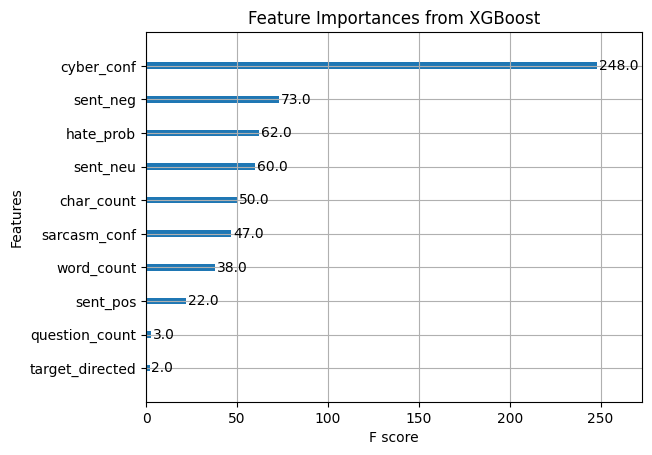

In [ ]:
features_df_clean = features_df.dropna(subset=["label"])

features_df_clean = features_df_clean.dropna()

# Separate features and label
X = features_df_clean.drop("label", axis=1)
# print(X)
y = features_df_clean["label"]
# print(X.shape, y.shape)
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print((X.nunique() == 1).sum(), "features are constant")
print("Label distribution:\n", y.value_counts())
print(X.select_dtypes(exclude=["number"]).columns)
print("Constant features:", [col for col in X.columns if X[col].nunique() == 1])
print("Rows that are all zeros:", (X == 0).all(axis=1).sum())


# print(X_train.shape)

# Define the XGBoost classifier and parameter grid for tuning
from sklearn.model_selection import ParameterGrid
from tqdm import tqdm
from sklearn.base import clone

# Estimate total number of iterations
total_iterations = len(ParameterGrid(param_grid)) * 3  # 3-fold CV

# Create a tqdm progress bar
progress_bar = tqdm(total=total_iterations, desc="GridSearch Progress", unit="iteration")

class TQDMGridSearchCV(GridSearchCV):
    def _run_search(self, evaluate_candidates):
        """Override this method to add progress bar updates."""
        def wrapper(candidate_params):
            progress_bar.update(len(candidate_params) * self.cv)
            return evaluate_candidates(candidate_params)
        super()._run_search(wrapper)

# Use the custom class
xgb_model = xgb.XGBClassifier(random_state=42, eval_metric='logloss')

grid_search = TQDMGridSearchCV(
    xgb_model,
    param_grid,
    cv=3,
    scoring="accuracy",
    verbose=0
)
grid_search.fit(X_train, y_train)

results = pd.DataFrame(grid_search.cv_results_)
print("\nGridSearch Results Summary:")
print(results[["mean_test_score", "params"]].sort_values("mean_test_score", ascending=False).head(10))

progress_bar.close()

# Results
best_model = grid_search.best_estimator_

print("\nBest Parameters from Grid Search:")
print(grid_search.best_params_)
print("\nTraining Accuracy: {:.2f}%".format(best_model.score(X_train, y_train) * 100))
print("Testing Accuracy: {:.2f}%".format(best_model.score(X_test, y_test) * 100))

# Plot importances
xgb.plot_importance(best_model)
plt.title("Feature Importances from XGBoost")
plt.show()

In [ ]:
import joblib
joblib.dump(best_model, "xgb_cyberbullying_model.pkl")

['xgb_cyberbullying_model.pkl']

In [3]:
import pandas as pd
import joblib
from sklearn.metrics import recall_score, precision_score, accuracy_score

# Load your trained XGBoost model
best_model = joblib.load("xgb_cyberbullying_model.pkl")

# Load and preprocess your dataset
df = pd.read_csv("twitter_parsed_dataset.csv")
df = df[:50000]

# Extract features (assuming all helper functions are already defined)
feature_list = []
true_labels = []

for idx, row in df.iterrows():
    raw_text = row["Text"]
    if pd.isna(raw_text) or not str(raw_text).strip():
        continue  # Skip empty or NaN texts

    features = extract_features(str(raw_text).strip())
    feature_list.append(features)
    true_labels.append(row["oh_label"])  # Assuming this is the ground-truth label

# Convert to DataFrame
features_df = pd.DataFrame(feature_list)
features_df["label"] = true_labels

# Drop rows with missing labels or features
features_df = features_df.dropna()

# Separate X and y
X = features_df.drop(columns=["label"])
y_true = features_df["label"]

# Get model predictions
y_pred = best_model.predict(X)

# Compute evaluation metrics
recall = recall_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
accuracy = accuracy_score(y_true, y_pred)

# Display results
print(f"Recall:    {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Accuracy:  {accuracy:.4f}")


FileNotFoundError: [Errno 2] No such file or directory: 'twitter_parsed_dataset.csv'

In [5]:
test_texts = [
    "You're a worthless piece of trash. No one likes you.",  # cyberbullying
    "Haha you're so dumb, it amazes me.",                    # cyberbullying
    "Get a life, loser. Go cry to your mommy.",              # cyberbullying
    "You are a wonderful person. Keep shining!",             # non-bullying
    "I disagree with your opinion, but I respect it.",       # non-bullying
    "Just saw your post. That was hilarious 😂",             # non-bullying
]
def test_cyberbullying_model(texts, model):
    all_features = []
    for text in texts:
        try:
            features = extract_features(text)
            all_features.append(features)
        except Exception as e:
            print(f"Error processing: {text} — {e}")
            all_features.append({col: np.nan for col in X.columns})

    test_df = pd.DataFrame(all_features)
    test_df = test_df.fillna(0)  # fallback, just in case

    predictions = model.predict(test_df)
    probabilities = model.predict_proba(test_df)[:, 1]  # probability of class 1 (cyberbullying)

    print("\n🧾 Prediction Results:\n")
    for text, pred, prob in zip(texts, predictions, probabilities):
        label = "Cyberbullying" if pred == 1 else "Not Cyberbullying"
        print(f"→ {text}")
        print(f"   Prediction: {label} ({prob:.2%} confidence)\n")

test_cyberbullying_model(test_texts, best_model)

Error processing: You're a worthless piece of trash. No one likes you. — name 'extract_features' is not defined


NameError: name 'X' is not defined

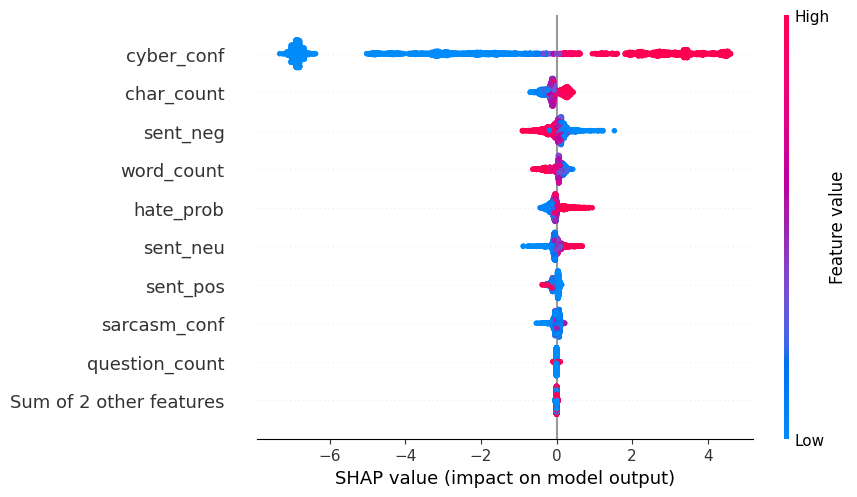

In [ ]:
import shap
explainer = shap.Explainer(best_model)
shap_values = explainer(X_test)

shap.plots.beeswarm(shap_values)


In [ ]:
# !pip install lime

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Defaulting to user installation because normal site-packages is not writeable
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 14.4 MB/s eta 0:00:00a 0:00:01
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283913 sha256=84c3c75d76e9969321d8ead322ba97ad3773d765d2e61c03a9c9faa61f713450
  Stored in directory: /Users/stygianphantom/Library/Caches/pip/wheels/ed/d7/c9/5a0130d06d6310bc6cbe55220e6e72dcb8c4eff9a478717066
Successfully built lime


In [ ]:
from lime.lime_text import LimeTextExplainer
import pandas as pd
import numpy as np

# Feature column names used in your model
feature_columns = X.columns.tolist()

# Your model's predict_proba logic wrapped for LIME
def predict_proba_for_lime(texts):
    feature_rows = []
    for text in texts:
        try:
            features = extract_features(text)  # You must define this function
        except Exception as e:
            print(f"Error extracting features: {e}")
            features = {col: 0 for col in feature_columns}
        feature_rows.append(features)

    df = pd.DataFrame(feature_rows).reindex(columns=feature_columns, fill_value=0)

    probs = best_model.predict_proba(df)
    if probs.shape[1] != 2:
        raise ValueError("predict_proba must return probabilities for both classes")

    return probs

# LIME setup with correct class order
class_names = ['not cyberbullying', 'cyberbullying']
explainer = LimeTextExplainer(class_names=class_names)

raw_texts = [
    "You're such a great friend, always supportive!",         # likely not cyberbullying
    "You are literally the worst human being ever",           # likely cyberbullying
    "Nobody likes you. Just leave already.",                  # harsh - borderline case
    "Hope you have a good day!"                               # clearly positive
]

# Choose one to explain
idx = 0  # try changing this to 0, 2, 3 to see different explanations
text_instance = raw_texts[idx]

# Generate explanation
exp = explainer.explain_instance(text_instance, predict_proba_for_lime, num_features=10)
exp.show_in_notebook()

# Optional: See predicted probabilities for sanity check
print("Sample probs:", predict_proba_for_lime([text_instance]))


Sample probs: [[0.24404061 0.7559594 ]]


In [113]:
idx = 0  # try changing this to 0, 2, 3 to see different explanations
text_instance = raw_texts[idx]

# Generate explanation
exp = explainer.explain_instance(text_instance, predict_proba_for_lime, num_features=10)
exp.show_in_notebook()

# Optional: See predicted probabilities for sanity check
print("Sample probs:", predict_proba_for_lime([text_instance]))
exp.save_to_file("lime_explanation2.html")

Sample probs: [[0.90827256 0.09172741]]



🌟 SHAP Explanation for Text:
"You're a worthless piece of trash. No one likes you."



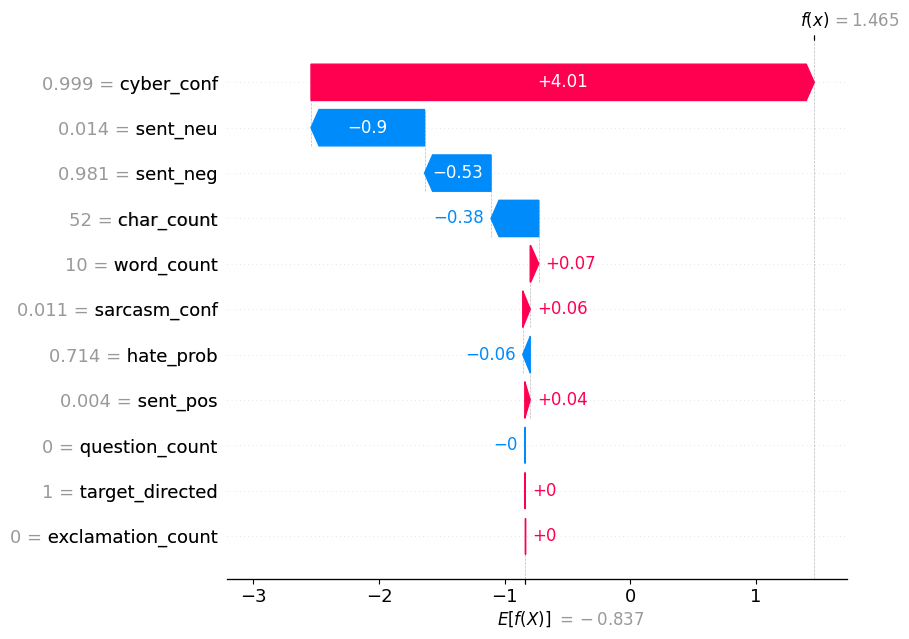

⚠️ Could not save as HTML: cannot import name 'convert_plot' from 'shap.plots._utils' (/Users/stygianphantom/Library/Python/3.9/lib/python/site-packages/shap/plots/_utils.py)


In [96]:
import shap
import pandas as pd
import matplotlib.pyplot as plt

# Initialize SHAP TreeExplainer once (outside the function if used repeatedly)
shap_explainer = shap.Explainer(best_model)

# Wrapper function: explain a single text using SHAP
def explain_with_shap(text, model, feature_columns):
    # 1. Extract features for the input text
    features = extract_features(text)

    # 2. Convert to DataFrame (SHAP expects DataFrame input)
    input_df = pd.DataFrame([features])[feature_columns]

    # 3. Generate SHAP values
    shap_values = shap_explainer(input_df)

    # 4. Plot waterfall explanation (similar to LIME bar view)
    print("\n🌟 SHAP Explanation for Text:")
    print(f"\"{text}\"\n")

    shap.plots.waterfall(shap_values[0], max_display=20)

    # 5. Optional: save as HTML
    try:
        from shap.plots._utils import convert_plot
        from IPython.display import HTML
        html = convert_plot(shap.plots.waterfall(shap_values[0], show=False))
        with open("shap_explanation.html", "w") as f:
            f.write(html.data)
        print("✅ SHAP explanation saved to: shap_explanation.html")
    except Exception as e:
        print(f"⚠️ Could not save as HTML: {e}")

text_to_explain = "You're a worthless piece of trash. No one likes you."
explain_with_shap(text_to_explain, best_model, feature_columns)



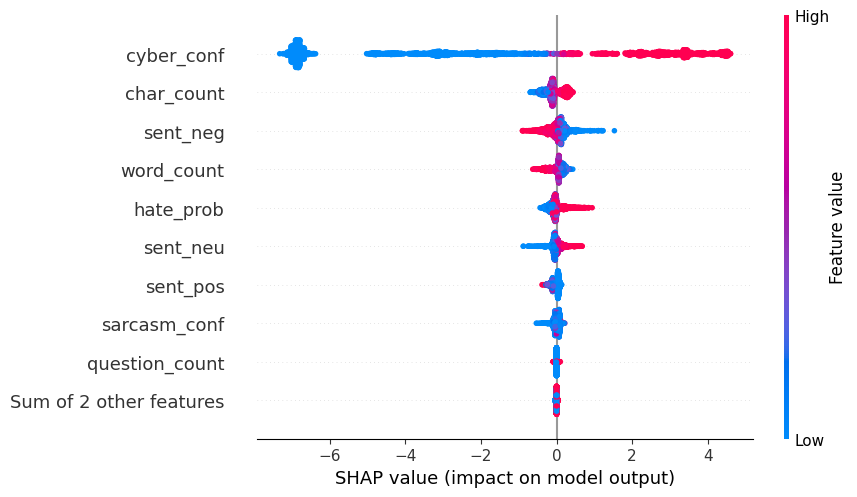

In [94]:
shap_values = explainer(X_test)
shap.plots.beeswarm(shap_values)  # shows global feature importance per class


In [104]:
import pandas as pd
import shap
import matplotlib.pyplot as plt

# ——— Replace with your actual functions ———
# from your_feature_module import extract_features, feature_columns
# from your_model_module   import best_model
# ————————————————————————————————

# Label class names properly
class_names = ["Not Cyberbullying", "Cyberbullying"]

def predict_proba(texts):
    safe_texts = [str(t) for t in texts]
    feat_dicts = [extract_features(t) for t in safe_texts]
    df = pd.DataFrame(feat_dicts)[feature_columns]
    return best_model.predict_proba(df)

def explain_text(text):
    if not isinstance(text, str):
        text = str(text)
    
    masker = shap.maskers.Text()
    explainer = shap.Explainer(
        predict_proba,
        masker,
        output_names=class_names
    )
    shap_values = explainer([text])
    return shap_values

if __name__ == "__main__":
    sample = "You're a worthless piece of trash. No one likes you."
    sv = explain_text(sample)

    shap.plots.text(sv[0])  # shows inline if in notebook

    html_str = shap.plots.text(sv[0], display=False)
    with open("shap_text_highlight.html", "w", encoding="utf-8") as f:
        f.write(html_str)
    print("✔️ Saved text highlight to shap_text_highlight.html")

    pred_class = sv[0].values.sum(axis=1).argmax()

    # Use SHAP values corresponding to that class
    tokens = sv[0].data
    scores = sv[0].values[:, pred_class]  # <- pick the class-specific scores

    # Zip and sort by importance
    token_scores = list(zip(tokens, scores))
    token_scores.sort(key=lambda x: abs(x[1]), reverse=True)

    print("\nTop Token Attributions:")
    for token, score in token_scores:
        print(f"{token:20s} → {score:+.4f}")

PartitionExplainer explainer: 2it [00:14, 14.42s/it]               


✔️ Saved text highlight to shap_text_highlight.html

Top Token Attributions:
you                  → -0.2078
You'                 → -0.1906
trash.               → -0.1335
one                  → -0.0821
likes                → -0.0699
worthless            → -0.0649
No                   → +0.0649
piece                → -0.0333
of                   → +0.0098
re                   → +0.0084
a                    → -0.0056


In [ ]:

import pandas as pd
import joblib

# 1) Load your trained meta-model
best_model = joblib.load("xgb_cyberbullying_model.pkl")  # adjust path if needed

# 2) Define the texts you want to inspect
raw_texts = [
    "You're such a great friend, always supportive!",
    "You are literally the worst human being ever",
    "Nobody likes you. Just leave already.",
    "Hope you have a good day!"
]

# 3) Build the interpretability table
interpret_rows = []
for text in raw_texts:
    feats = extract_features(text)                             # your helper function
    df_feats = pd.DataFrame([feats])
    proba = best_model.predict_proba(df_feats)[0, 1]           # P(cyberbullying)
    label = "Cyberbullying" if proba > 0.5 else "Not Cyberbullying"

    interpret_rows.append({
        "Text":           text,
        "Cyber_Conf":     round(feats["cyber_conf"], 3),
        "Hate_Prob":      round(feats["hate_prob"], 3),
        "Sent_Neg":       round(feats["sent_neg"], 3),
        "Sent_Neu":       round(feats["sent_neu"], 3),
        "Sent_Pos":       round(feats["sent_pos"], 3),
        "Sarcasm_Conf":   round(feats["sarcasm_conf"], 3),
        "Directed":       feats["target_directed"],
        "Word_Count":     feats["word_count"],
        "Char_Count":     feats["char_count"],
        "Excl_Count":     feats["exclamation_count"],
        "Quest_Count":    feats["question_count"],
        "Final_Proba":    round(proba, 3),
        "Final_Label":    label
    })

# 4) Create DataFrame and print it
interpret_df = pd.DataFrame(interpret_rows)
print(interpret_df.to_markdown(index=False))


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Defaulting to user installation because normal site-packages is not writeable
  Using cached tabulate-0.9.0-py3-none-any.whl.metadata (34 kB)
Using cached tabulate-0.9.0-py3-none-any.whl (35 kB)

[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
| Text                                           |   Cyber_Conf |   Hate_Prob |   Sent_Neg |   Sent_Neu |   Sent_Pos |   Sarcasm_Conf |   Directed |   Word_Count |   Char_Count |   Excl_Count |   Quest_Count |   Final_Proba | Final_Label       |
|:-----------------------------------------------|-------------:|------------:|-----------:|-----------:|-----------:|---------------:|-----------:|-------------:|-------------:|-------------:|--------------:|--------------:|:------------------|
| You're such a great friend, always supportive! |        0.007 |       0.594 |      0.002 |      0.007 |      0.99  |          0.009 |          1 